In [3]:
# !pip install deap
# !pip install scipy
# !pip install deap numpy pandas scipy
# !pip install numpy
# !pip install pandas
# !pip install geopy
# !pip install matplotlib
# !pip install seaborn
# # !pip install --upgrade setuptools
# !pip install sklearn
# !pip install openpyxl
# !pip install xlrd
# !pip install xlwt
# !pip install xlsxwriter
import pandas as pd
import numpy as np
import random
import math
from math import radians, sin, cos, sqrt
from geopy.distance import geodesic
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
url = '/content/drive/MyDrive/לימודים/final project/קודים גמורים /Data/data_1.csv'
df= pd.read_csv(url)

In [6]:
df.head()

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע
0,1/1 17:39,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,1/1 17:39,1/1 18:16,נסגר בהצלחה
1,1/1 17:39,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,1/1 18:27,1/1 18:37,נסגר בהצלחה
2,1/1 17:39,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,1/1 18:28,NaN,נסגר בהצלחה
3,1/1 17:41,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,1/1 19:51,NaN,נסגר בהצלחה
4,1/1 17:43,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,1/1 17:56,1/1 18:06,נסגר בהצלחה


# תחילת עבודה עם הנתונים

In [7]:
# מחיקת שורות שבהן ארבע עמודות ספציפיות ריקות
df.dropna(subset=['זמן סגירה','זמן לקיחה'], how='all', inplace=True)

# שומרים את התוצאה לקובץ חדש /מעדכנים את הקובץ המקורי
df.to_csv('df.csv', index=False)  # שימו לב ש־index=False

In [8]:
# מחיקת שורות שבהן שתי עמודות ספציפיות ריקות
df.dropna(subset=['קטגוריה'], how='all', inplace=True)
df.dropna(subset=['סטטוס אירוע'], how='all', inplace=True)
df.dropna(subset=['מזהה כונן'], how='all', inplace=True)
# שומרים את התוצאה לקובץ חדש /מעדכנים את הקובץ המקורי
df.to_csv('df.csv', index=False)  # שימו לב ש־index=False מוסיף נתון ללא טעות

In [9]:
df['זמן לקיחה'] = pd.to_datetime(df['זמן לקיחה'], format='%d/%m %H:%M', errors='coerce').apply(lambda x: x.replace(year=2022) if x.year == 1900 else x)
df['זמן סגירה'] = pd.to_datetime(df['זמן סגירה'], format='%d/%m %H:%M', errors='coerce').apply(lambda x: x.replace(year=2022) if x.year == 1900 else x)
df['זמן'] = pd.to_datetime(df['זמן'], format='%d/%m %H:%M', errors='coerce').apply(lambda x: x.replace(year=2022) if x.year == 1900 else x)

In [10]:
# סינון הנתונים לשורות שיש בהן נתונים בשני העמודות המעניינות
filtered_df = df.dropna(subset=['זמן לקיחה', 'זמן סגירה'])

In [11]:
# חישוב זמן הטיפול עם התחשבות במעברים ליום הבא
df['זמן טיפול'] = df.apply(lambda row: row['זמן סגירה'] - row['זמן לקיחה'] if row['זמן סגירה'] >= row['זמן לקיחה'] else row['זמן סגירה'] + pd.Timedelta(days=1) - row['זמן לקיחה'], axis=1)

In [12]:
# איתור ערכים שליליים בעמודת זמן טיפול
negative_treatment_time = df[df['זמן טיפול'] < pd.Timedelta(0)]
df = df[~df.index.isin(negative_treatment_time.index)]

In [13]:
# המרה של עמודת 'זמן טיפול' לתאריך ושעה (timedelta)
df['זמן טיפול'] = pd.to_timedelta(df['זמן טיפול'])

# זיהוי ערכים שליליים בעמודת 'זמן טיפול' ושינוי שנת 'זמן סגירה'
negative_values_mask = df['זמן טיפול'] < pd.Timedelta(0)
df.loc[negative_values_mask, 'זמן סגירה'] += pd.DateOffset(years=1)

<ipython-input-13-4464501a8492>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['זמן טיפול'] = pd.to_timedelta(df['זמן טיפול'])


In [14]:
# חישוב הזמן הממוצע לתקלה לפי הקטגוריה
average_time_per_category = df.groupby('קטגוריה').apply(lambda x: (x['זמן סגירה'] - x['זמן לקיחה']).mean())
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00,נסגר בהצלחה,0 days 00:37:00
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00,נסגר בהצלחה,0 days 00:10:00
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,NaT,נסגר בהצלחה,NaT
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,NaT,נסגר בהצלחה,NaT
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00,נסגר בהצלחה,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,NaT,נסגר בהצלחה,NaT
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,NaT,נסגר בהצלחה,NaT
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00,נסגר בהצלחה,0 days 00:05:00
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00,נסגר בהצלחה,0 days 00:40:00


In [15]:
def add_average_time_close(row):
    if pd.isna(row['זמן סגירה']):
        new_closure_time_close = row['זמן לקיחה'] + average_time_per_category[row['קטגוריה']]
        return new_closure_time_close
    return row['זמן סגירה']

In [16]:
# הוספת הזמן הממוצע לשורות שבהן אין ערך בעמודה 'זמן סגירה'
df['זמן סגירה'] = df.apply(add_average_time_close, axis=1)

In [17]:
def add_average_time_open(row):
    if pd.isna(row['זמן לקיחה']):
        new_closure_time_open = row['זמן סגירה'] - average_time_per_category[row['קטגוריה']]
        return new_closure_time_open
    return row['זמן לקיחה']

# הוספת הזמן הממוצע לשורות שבהן אין ערך בעמודה 'זמן סגירה'
df['זמן לקיחה'] = df.apply(add_average_time_open, axis=1)

In [18]:
# חישוב זמן הטיפול עם התחשבות במעברים ליום הבא
df['זמן טיפול'] = df.apply(lambda row: row['זמן סגירה'] - row['זמן לקיחה'] if row['זמן סגירה'] >= row['זמן לקיחה'] else row['זמן סגירה'] + pd.Timedelta(days=1) - row['זמן לקיחה'], axis=1)

In [19]:
# פונקציה להמרת timedelta לדקות
def convert_to_minutes(td):
    if isinstance(td, pd.Timedelta):
        return td.total_seconds() / 60
    else:
        return td # Return the original value if it's not a timedelta

# המרת עמודת 'ממוצע זמן טיפול בתקלה' לדקות
df['זמן טיפול'] = df['זמן טיפול'].apply(convert_to_minutes)
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000
...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000


In [20]:
print(df[['זמן לקיחה', 'זמן סגירה','זמן טיפול']].dtypes)

זמן לקיחה    datetime64[ns]
זמן סגירה    datetime64[ns]
זמן טיפול           float64
dtype: object


In [21]:
#df.groupby('קטגוריה')['זמן טיפול'].transform('mean')

In [22]:
df.loc[df['זמן טיפול'] == '00:00:00', 'סטטוס אירוע'] = 'בוטל'

In [23]:
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000
...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000


קטגוריה
אחר                      25.280388
דלת                      24.568449
הנעה                     18.064785
חילוץ שטח                16.000000
פנצ'ר                    25.305340
קורונה - קניית אוכל      61.960000
קורונה - קניית תרופות    43.167883
קורונה - שינוע מזון      29.843750
רכב נעול                 24.669174
שינוע                    31.228216
שמן-מים-דלק              23.869202
Name: זמן טיפול, dtype: float64


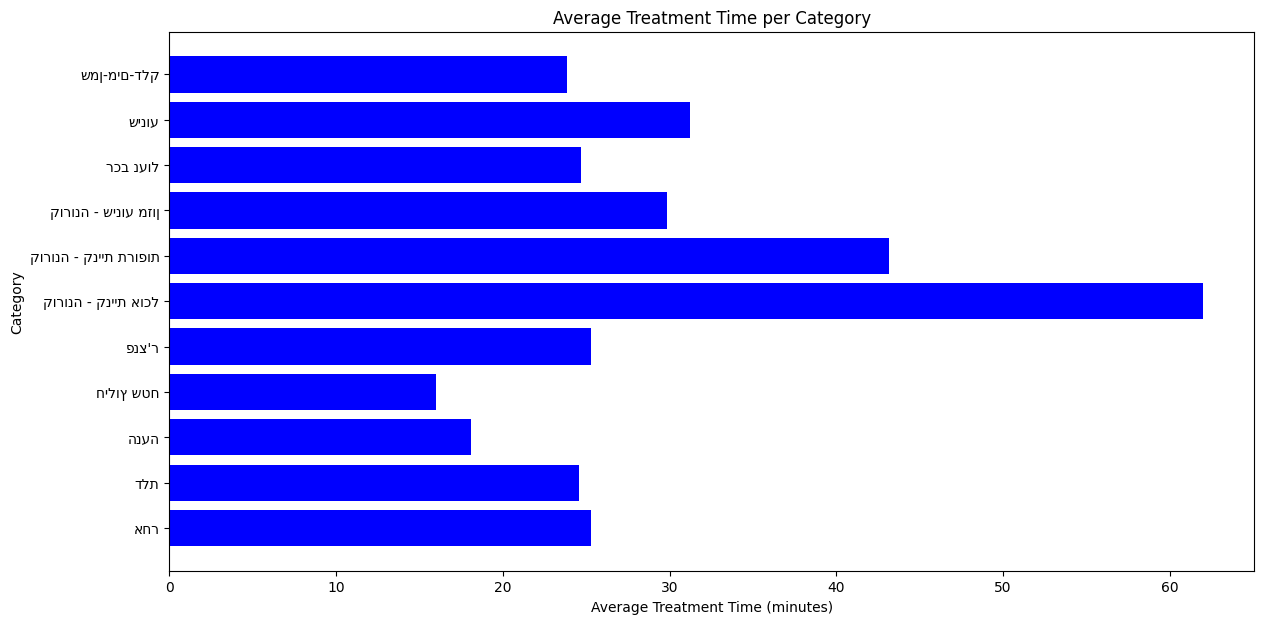

In [24]:
# חישוב זמן טיפול ממוצע לכל קטגוריה
avg_treatment_time_per_category = df.groupby('קטגוריה')['זמן טיפול'].mean()

# הצגת התוצאות של זמן טיפול ממוצע לכל קטגוריה
print(avg_treatment_time_per_category)

# גרף זמן טיפול ממוצע לפי קטגוריה
plt.figure(figsize=(14, 7))
plt.barh(avg_treatment_time_per_category.index, avg_treatment_time_per_category.values, color='blue')
plt.title('Average Treatment Time per Category')
plt.xlabel('Average Treatment Time (minutes)')
plt.ylabel('Category')
plt.show()

ניתן להסיק כמה דברים חשובים לגבי זמן הטיפול הממוצע לפי קטגוריה לפני ההטמעה:
הקטגוריות עם זמן הטיפול הממוצע הגבוה ביותר:
"קורונה - קניית אוכל" :קטגוריה זו מציגה את זמן הטיפול הממוצע הגבוה ביותר, מעל 60 דקות.
הקטגוריות עם זמן הטיפול הממוצע הנמוך ביותר:
"הנעה": קטגוריה זו מציגה את זמן הטיפול הממוצע הנמוך ביותר, כ-18 דקות.
"חילוץ שטח": קטגוריה זו מציגה זמן טיפול ממוצע נמוך יחסית של כ-16 דקות.

בהתבסס על הנתונים האלו, נבחן מדוע קטגוריות מסוימות, מציגות זמן טיפול ממוצע גבוה במיוחד. ייתכן שיש בעיות בתהליך או בציוד המשמש לטיפול באירועים אלו.
נבצע ניתוח מעמיק של כל שלבי הטיפול באירועים בקטגוריות אלו כדי לזהות חסמים וקשיים.

קטגוריה
אחר            25.280388
דלת            24.568449
הנעה           18.064785
חילוץ שטח      16.000000
פנצ'ר          25.305340
רכב נעול       24.669174
שינוע          31.228216
שמן-מים-דלק    23.869202
Name: זמן טיפול, dtype: float64


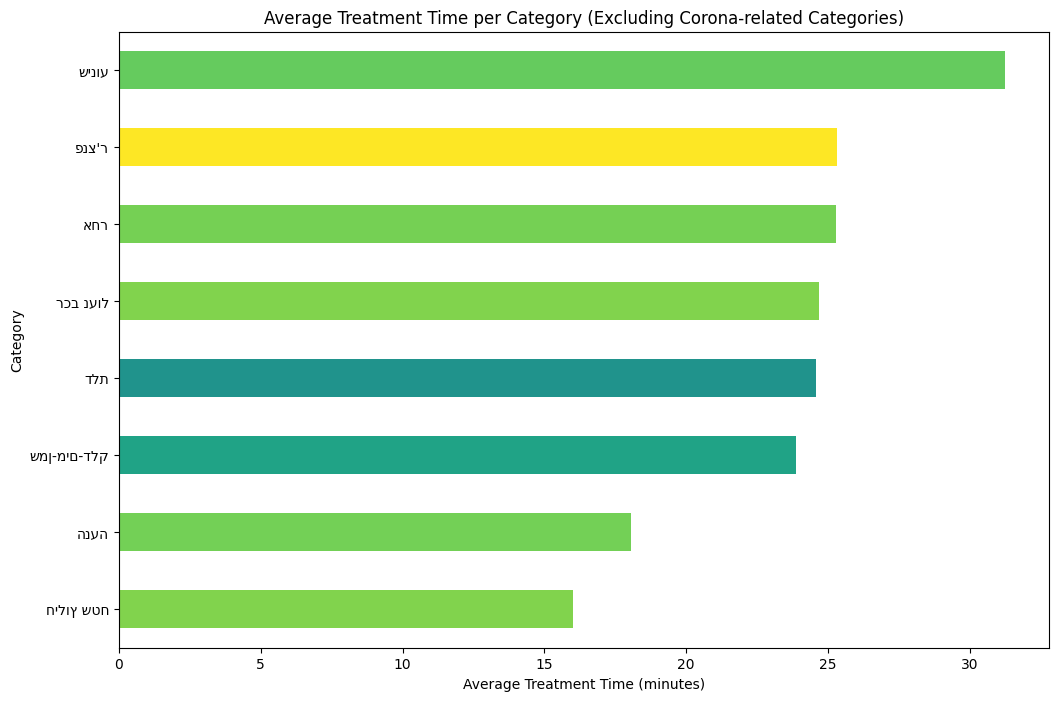

In [25]:
# סינון הנתונים להסרת קטגוריות הקורונה
nocorona_df = df[~df['קטגוריה'].str.contains('קורונה')]

# חישוב זמן טיפול ממוצע לכל קטגוריה ללא הקטגוריות המסוננות
avg_treatment_time_per_category_filtered = nocorona_df.groupby('קטגוריה')['זמן טיפול'].mean()
print(avg_treatment_time_per_category_filtered)
# יצירת רשימת צבעים המשתנה בהתאם לגובה העמודות
colors = plt.cm.viridis(avg_treatment_time_per_category_filtered / max(avg_treatment_time_per_category_filtered))
# הצגת הגרף החדש
plt.figure(figsize=(12, 8))
avg_treatment_time_per_category_filtered.sort_values().plot(kind='barh', color=colors)
plt.title('Average Treatment Time per Category (Excluding Corona-related Categories)')
plt.xlabel('Average Treatment Time (minutes)')
plt.ylabel('Category')
plt.show()

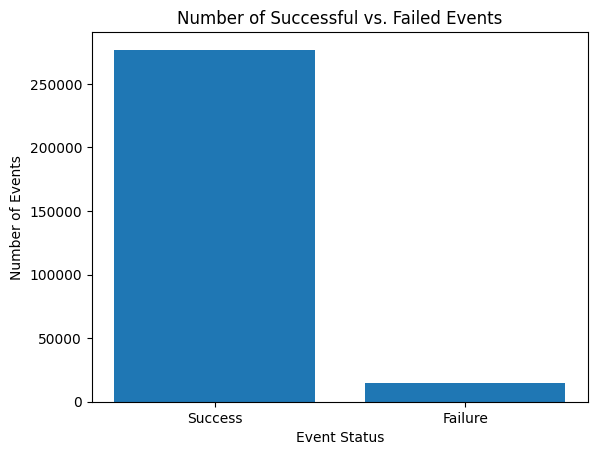

In [26]:
# Assuming 'df' is your DataFrame and it has a column named 'סטטוס אירוע'
success_count = df[df['סטטוס אירוע'] == 'נסגר בהצלחה'].shape[0]
failure_count = df[df['סטטוס אירוע'] == 'נסגר ללא הצלחה'].shape[0]
# Creating the bar chart
plt.bar(['Success', 'Failure'], [success_count, failure_count])
plt.xlabel('Event Status')
plt.ylabel('Number of Events')
plt.title('Number of Successful vs. Failed Events')
plt.show()

הערכה גסה של הארגון על מנת לקחת בחשבון כמה שיותר נתונים לבניית ואימון המודל

In [27]:
# חישוב זמן טיפול ממוצע לכל קטגוריה
df['זמן טיפול ממוצע'] = df.groupby('קטגוריה')['זמן טיפול'].transform('mean')

# פונקציה לבדיקת זמן טיפול
def check_treatment_time(row):
    if pd.isna(row['זמן טיפול']) or pd.isna(row['זמן טיפול ממוצע']): # Check for NaT values
        return False
    if row['זמן טיפול'] > 10 * row['זמן טיפול ממוצע']:
        return True
    return False

# החלת הפונקציה על כל שורה ובדיקת התנאי
df['חריג זמן טיפול'] = df.apply(check_treatment_time, axis=1)

# סינון השורות שבהן זמן הטיפול חריג
outliers_df = df[df['חריג זמן טיפול'] == True]
df=df[df['חריג זמן טיפול'] == False]
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,חריג זמן טיפול
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000,18.064785,False
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000,25.305340,False
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697,25.305340,False
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697,25.305340,False
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000,18.064785,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653,18.064785,False
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388,25.280388,False
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000,25.305340,False
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000,18.064785,False


In [28]:
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,חריג זמן טיפול
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000,18.064785,False
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000,25.305340,False
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697,25.305340,False
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697,25.305340,False
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000,18.064785,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653,18.064785,False
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388,25.280388,False
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000,25.305340,False
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000,18.064785,False


המרחק הוא פרמטר שהמלצנו לארגון לשקול בתור חלק מהפתרון.

המגמה לשיפור מתחילה בנקודת המבט של המתנדב הניגש לקריאה מסוימת, ישנו עניין המרחק באותו הזמן, שמהווה פרטמר חשוב בעניין זמן הטיפול בקריאה ויש לקחת בחשבון

In [29]:
# הגדרת תחום הקואורדינטות של ישראל
min_latitude = 29.5
max_latitude = 33.3
min_longitude = 34.2
max_longitude = 35.7

# פונקציה ליצירת קואורדינטות רנדומליות
def generate_random_coordinates(num_points):
    coordinates = []
    for _ in range(num_points):
        lat = random.uniform(min_latitude, max_latitude)
        lon = random.uniform(min_longitude, max_longitude)
        coordinates.append((lat, lon))
    return coordinates

# יצירת קואורדינטות חדשות
num_points = len(df)  # מספר השורות בקובץ הקיים
new_coordinates = generate_random_coordinates(num_points)

# הוספת העמודות החדשות לDataFrame הקיים
df['קו רוחב תקלה'] = [coord[0] for coord in new_coordinates]
df['קו אורך תקלה'] = [coord[1] for coord in new_coordinates]

<ipython-input-29-f88d1528acba>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['קו רוחב תקלה'] = [coord[0] for coord in new_coordinates]
<ipython-input-29-f88d1528acba>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['קו אורך תקלה'] = [coord[1] for coord in new_coordinates]


In [30]:
# פונקציה לחישוב מרחק בין שני נקודות גיאוגרפיות בקילומטרים
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # רדיוס של כדור הארץ בקילומטרים
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * math.atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# פונקציה ליצירת קואורדינטות רנדומליות תוך כדי עמידה בתוקף
def generate_random_coordinates_within_range(original_coordinate, max_distance_km=7):
    lat, lon = original_coordinate
    while True:
        # יצירת קואורדינטה רנדומלית בתחום המבוקש
        random_lat = random.uniform(max(lat - 0.063, min_latitude), min(lat + 0.063, max_latitude))
        random_lon = random.uniform(max(lon - 0.063, min_longitude), min(lon + 0.063, max_longitude))

        # בדיקה שהקואורדינטה הרנדומלית נמצאת במרחק המבוקש מהקואורדינטה המקורית
        if haversine_distance(lat, lon, random_lat, random_lon) <= max_distance_km:
            return (random_lat, random_lon)

# יצירת קואורדינטות חדשות
new_coordinates = []
for _, row in df.iterrows():
    original_lat, original_lon = row['קו רוחב תקלה'], row['קו אורך תקלה']
    new_coord = generate_random_coordinates_within_range((original_lat, original_lon))
    new_coordinates.append(new_coord)

# הוספת העמודות החדשות לDataFrame הקיים
df['קו רוחב מתנדב'] = [coord[0] for coord in new_coordinates]
df['קו אורך מתנדב'] = [coord[1] for coord in new_coordinates]

<ipython-input-30-fc9b44084ac6>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['קו רוחב מתנדב'] = [coord[0] for coord in new_coordinates]
<ipython-input-30-fc9b44084ac6>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['קו אורך מתנדב'] = [coord[1] for coord in new_coordinates]


In [31]:
# פונקציה לחישוב המרחק בקילומטרים בין שני נקודות
def calculate_distance(row):
    # בדיקה שהנתונים בעמודות הקואורדינטות נמצאים בתחום הקואורדינטות של ישראל
    if min_latitude <= row['קו רוחב תקלה'] <= max_latitude and min_longitude <= row['קו אורך תקלה'] <= max_longitude:
        point1 = (row['קו רוחב תקלה'], row['קו אורך תקלה'])  # הנקודה הראשונה
        point2 = (row['קו רוחב מתנדב'], row['קו אורך מתנדב'])  # הנקודה השנייה (אם קיימת)

        # חישוב המרחק בקילומטרים בין הנקודות
        return geodesic(point1, point2).kilometers
    else:
        return None  # או ערך ריק אחר לא תומך בחישוב

# הוספת עמודה חדשה לדאטה שלך עם המרחקים בקילומטרים
df['מרחק בק"מ'] = df.apply(calculate_distance, axis=1)

<ipython-input-31-3999a4e9fddc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['מרחק בק"מ'] = df.apply(calculate_distance, axis=1)


In [32]:
df['דירוג לקוח'] = np.random.randint(1, 6, size=len(df))

<ipython-input-32-577841562ce6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['דירוג לקוח'] = np.random.randint(1, 6, size=len(df))


In [33]:
df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,חריג זמן טיפול,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000,18.064785,False,32.132258,34.762482,32.092857,34.787374,4.960651,1
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000,25.305340,False,31.477073,34.765542,31.465063,34.727233,3.876492,2
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,30.270292,34.709047,30.233857,34.759768,6.335924,4
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,30.944389,34.366903,30.933122,34.309525,5.623835,5
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000,18.064785,False,30.232903,35.397713,30.205600,35.427829,4.191322,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343597,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653,18.064785,False,30.670777,35.328311,30.644620,35.266548,6.591736,2
343598,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388,25.280388,False,31.373107,35.464322,31.424109,35.465268,5.655606,4
343599,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000,25.305340,False,30.177661,35.458326,30.167546,35.422138,3.661486,3
343600,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000,18.064785,False,30.617764,35.028179,30.616715,34.994273,3.253067,1


In [34]:
output_file = 'clean_data.csv'
df.to_csv(output_file, index=False)

In [35]:
# !pip install geopy
import pandas as pd
import numpy as np
import random
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
url1 = '/content/clean_data.csv'
clean_df= pd.read_csv(url1)

<ipython-input-36-ecf1ce1cdd1f>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_df= pd.read_csv(url1)


**User Data:**

In [37]:
url_clean_data = '/content/drive/MyDrive/לימודים/final project/קודים גמורים /Data/clean_data.csv'
clean_data_df= pd.read_csv(url_clean_data)
clean_data_df.head()

<ipython-input-37-4db93ba888ed>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_data_df= pd.read_csv(url_clean_data)


,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,חריג זמן טיפול,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00.000000000,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000,18.064785,False,32.739057,35.236570,32.764670,35.227373,2.968398,2.0
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00.000000000,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000,25.305340,False,30.218503,34.374803,30.185443,34.399038,4.344723,2.0
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00.000000000,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,32.715484,35.275912,32.704803,35.286877,1.568408,1.0
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00.000000000,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,33.164280,35.110036,33.142977,35.154884,4.804959,3.0
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00.000000000,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000,18.064785,False,30.135537,34.541962,30.162403,34.536735,3.020540,1.0


In [38]:
missing_time = clean_data_df['זמן טיפול'].isna().sum()
missing_time

1

In [39]:
# zero_time = (clean_data_df['זמן טיפול'] == 0).sum()
# zero_time

In [40]:
clean_data_df = clean_data_df.dropna(subset=['זמן טיפול'])
#היו 2 שורות שהוסרו
# סינון השורות עם ערך מסוים בעמודה מסוימת
clean_data_df= clean_data_df[clean_data_df["מזהה כונן"] != " "]

In [41]:
# שינוי ערכים בעמודה סטטוס אירוע למספרים על פי התנאים הנתונים
status_mapping = {
    'נסגר בהצלחה': 1,
    'נסגר ללא הצלחה': 0,
    'בוטל': 0,
    'הוחזר': 2
}
clean_data_df['סטטוס אירוע'] = clean_data_df['סטטוס אירוע'].map(status_mapping)

# יצירת עמודה חדשה 'הצלחה' על פי הערכים בעמודה 'סטטוס אירוע'
success_mapping = {
    1: 1,
    0: 0,
    2: 0
}
clean_data_df['הצלחה'] = clean_data_df['סטטוס אירוע'].map(success_mapping)

# המרת הערכים של הזמן לפורמט timedelta
#df['זמן טיפול'] = pd.to_timedelta(df['זמן טיפול'])

# פונקציה לחישוב ממוצע זמן טיפול
def calculate_average_time(group):
    total_time = group.sum()
    average_time = total_time / len(group)
    return average_time

# קביעת הגישה לקבוצות לפי מזהה כונן וקטגוריה
grouped = clean_data_df.groupby(['מזהה כונן', 'קטגוריה'])

# חישוב ממוצע הזמן לטיפול בתקלה לכל קטגוריה וכונן
average_time = grouped['זמן טיפול'].apply(calculate_average_time)

# חישוב כמות האירועים והאירועים המוצלחים
event_counts = clean_data_df.groupby(['מזהה כונן', 'קטגוריה']).size().reset_index(name='כמות אירועים')
successful_events = clean_data_df[clean_data_df['סטטוס אירוע'] == 1].groupby(['מזהה כונן', 'קטגוריה']).size().reset_index(name='אירועים מוצלחים')

# פילטר על הערכים 'הצלחה' 0 או 1
filtered_df = clean_data_df[clean_data_df['הצלחה'].isin([0, 1])]

# חישוב אחוזי ההצלחה של כל כונן עבור כל קטגוריה
success_rates = filtered_df.groupby(['מזהה כונן', 'קטגוריה']).agg(
    סך_הכל_אירועים=pd.NamedAgg(column='הצלחה', aggfunc='count'),
    סך_הכל_הצלחות=pd.NamedAgg(column='הצלחה', aggfunc='sum')
).reset_index()

# הוספת עמודה של אחוזי הצלחה
success_rates['אחוזי הצלחה'] = (success_rates['סך_הכל_הצלחות'] / success_rates['סך_הכל_אירועים']) * 100

# חישוב ממוצע הדירוג לקוח לכל כונן באופן גלובלי
global_average_rating = clean_data_df.groupby('מזהה כונן')['דירוג לקוח'].mean().reset_index(name='ממוצע דירוג לקוח ')

# בניית DataFrame סופי לפי הדרישות
final_df = pd.DataFrame({
    'ממוצע זמן טיפול בתקלה': average_time
}).reset_index()

# מיזוג עם נתוני כמות האירועים והאירועים המוצלחים
final_df = final_df.merge(event_counts, on=['מזהה כונן', 'קטגוריה'], how='left')
final_df = final_df.merge(successful_events, on=['מזהה כונן', 'קטגוריה'], how='left')

# מיזוג עם נתוני אחוזי ההצלחה
final_df = final_df.merge(success_rates[['מזהה כונן', 'קטגוריה', 'אחוזי הצלחה']], on=['מזהה כונן', 'קטגוריה'], how='left')

# מיזוג עם ממוצע דירוג לקוח גלובלי
final_df = final_df.merge(global_average_rating, on='מזהה כונן', how='left')

# הדפסת התוצאה הסופית
final_df

,מזהה כונן,קטגוריה,ממוצע זמן טיפול בתקלה,כמות אירועים,אירועים מוצלחים,אחוזי הצלחה,ממוצע דירוג לקוח
0,0000 אבי,הנעה,13.000000,1,1.0,100.000000,2.000000
1,0000 אביחי,הנעה,9.000000,2,2.0,100.000000,2.500000
2,0000 אביטל,הנעה,18.046653,1,NaN,NaN,2.000000
3,0000 ישראל,הנעה,16.069465,69,60.0,86.956522,3.094595
4,0000 ישראל,פנצ'ר,37.430566,3,3.0,100.000000,3.094595
...,...,...,...,...,...,...,...
21800,9999 אלעזר,הנעה,22.624923,23,23.0,100.000000,3.230769
21801,9999 אלעזר,פנצ'ר,23.527798,3,3.0,100.000000,3.230769
21802,9999 דוד,הנעה,19.392495,8,8.0,100.000000,2.888889
21803,9999 דוד,פנצ'ר,35.000000,1,1.0,100.000000,2.888889


In [42]:
final_df['אירועים מוצלחים'] = final_df['אירועים מוצלחים'].fillna(0)
final_df['אחוזי הצלחה'] = final_df['אחוזי הצלחה'].fillna(0)
final_df

,מזהה כונן,קטגוריה,ממוצע זמן טיפול בתקלה,כמות אירועים,אירועים מוצלחים,אחוזי הצלחה,ממוצע דירוג לקוח
0,0000 אבי,הנעה,13.000000,1,1.0,100.000000,2.000000
1,0000 אביחי,הנעה,9.000000,2,2.0,100.000000,2.500000
2,0000 אביטל,הנעה,18.046653,1,0.0,0.000000,2.000000
3,0000 ישראל,הנעה,16.069465,69,60.0,86.956522,3.094595
4,0000 ישראל,פנצ'ר,37.430566,3,3.0,100.000000,3.094595
...,...,...,...,...,...,...,...
21800,9999 אלעזר,הנעה,22.624923,23,23.0,100.000000,3.230769
21801,9999 אלעזר,פנצ'ר,23.527798,3,3.0,100.000000,3.230769
21802,9999 דוד,הנעה,19.392495,8,8.0,100.000000,2.888889
21803,9999 דוד,פנצ'ר,35.000000,1,1.0,100.000000,2.888889


In [43]:
# זיהוי הערך החריג בקטגוריות
outlier = final_df[final_df['קטגוריה'].str.contains('2022-05-09')]
outlier
# הסרת הערך החריג
final_df = final_df[~final_df['קטגוריה'].str.contains('2022-05-09')]

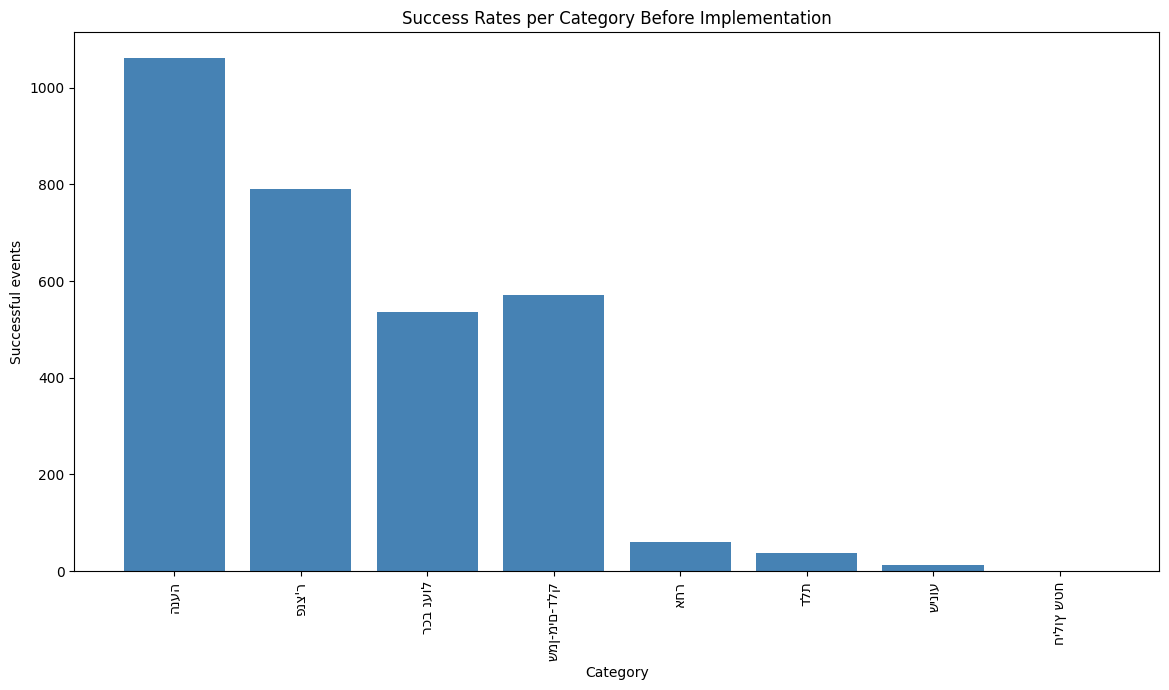

In [44]:
#נציג את אחוזי ההצלחה לפי קטגוריה וכונן, כדי לקבל תמונה ברורה על היעילות של כל קטגוריה וכונן לפני ההטמעה.
nocorona_df = final_df[~final_df['קטגוריה'].str.contains('קורונה')]

plt.figure(figsize=(14, 7))
plt.bar(nocorona_df['קטגוריה'], nocorona_df['אירועים מוצלחים'], color='steelblue')
plt.title('Success Rates per Category Before Implementation')
plt.xlabel('Category')
plt.ylabel('Successful events')
plt.xticks(rotation=90)  # סיבוב הטקסט של הקטגוריות ב-90 מעלות
plt.show()

קטגוריות עם מספר האירועים המוצלחים הגבוה ביותר:

הקטגוריה "הנעה" מציגה את מספר האירועים המוצלחים הגבוה ביותר, עם כ-1200 אירועים מוצלחים.
הקטגוריה "פנצ'ר" גם היא מציגה מספר גבוה של אירועים מוצלחים, עם כ-800 אירועים מוצלחים.
קטגוריות עם מספר האירועים המוצלחים הנמוך ביותר:

הקטגוריות תחת סיוע בתקופה הקורונה מציגות מספר קלוש של אירועים מוצלחים.
הקטגוריות "שינוע", "דלת" ו"אחר" מציגות מספר נמוך יחסית של אירועים מוצלחים.
המלצות לשיפור
חיזוק הקטגוריות המובילות:
כדאי להמשיך לחזק את הקטגוריות המובילות על ידי שיפור תהליכי העבודה והמשאבים הזמינים.
שיפור תהליכי עבודה ותיאום:
יש לבחון ולשפר את תהליכי העבודה והתקשורת בין המתנדבים, במיוחד בקטגוריות שבהן אחוזי ההצלחה נמוכים.

In [45]:
output_file = 'user_data_table.csv'
final_df.to_csv(output_file, index=False)

In [46]:
# # Define a function to identify outliers using the IQR method
# def find_outliers_iqr(data, column):
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
#     return outliers

# # Identify outliers in the 'כמות אירועים' column
# outliers = find_outliers_iqr(final_df, 'ממוצע זמן טיפול בתקלה בדקות')

# # Display the first few rows of the outliers
# outliers

# בניית מודל

חישוב המשקלים :
לאחר בדיקה עם סמנכ"ל טכנולוגיות בארגון הוהברה חשיבות המשקלים ל3 הפרמטרים שהוגדרו כמדדים .
ועל סמך הדיון המשכנו הלאה לחישוב המשקלים האוטימליים שיובילו לציון המאפיין מתנדב -בשאיפה כמובן לאופטימאלי ביותר

In [47]:
# קריאת הנתונים מקובץ ה-CSV
user_data_table = pd.read_csv('/content/drive/MyDrive/לימודים/final project/קודים גמורים /Data/user_data_table.csv')
clean_data_df = pd.read_csv('/content/drive/MyDrive/לימודים/final project/קודים גמורים /Data/clean_data.csv')

<ipython-input-47-8063b882f8d5>:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_data_df = pd.read_csv('/content/drive/MyDrive/לימודים/final project/קודים גמורים /Data/clean_data.csv')


In [48]:
### לא למחוק את השורה הזאת
user_data_table = user_data_table.dropna(subset=['ממוצע דירוג לקוח '])

In [49]:
user_data_table

,מזהה כונן,קטגוריה,ממוצע זמן טיפול בתקלה,כמות אירועים,אירועים מוצלחים,אחוזי הצלחה,ממוצע דירוג לקוח
0,0000 אבי,הנעה,13.000000,1,1.0,100.000000,2.000000
1,0000 אביחי,הנעה,9.000000,2,2.0,100.000000,2.500000
2,0000 אביטל,הנעה,18.046653,1,0.0,0.000000,2.000000
3,0000 ישראל,הנעה,16.069465,69,60.0,86.956522,3.094595
4,0000 ישראל,פנצ'ר,37.430566,3,3.0,100.000000,3.094595
...,...,...,...,...,...,...,...
21800,9999 אלעזר,הנעה,22.624923,23,23.0,100.000000,3.230769
21801,9999 אלעזר,פנצ'ר,23.527798,3,3.0,100.000000,3.230769
21802,9999 דוד,הנעה,19.392495,8,8.0,100.000000,2.888889
21803,9999 דוד,פנצ'ר,35.000000,1,1.0,100.000000,2.888889


In [50]:
# שלב 2: חישוב הממוצעים של כל עמודה לפי קטגוריות עבור העמודות הרלוונטיות בלבד
columns_to_average = ['ממוצע זמן טיפול בתקלה', 'ממוצע דירוג לקוח ', 'אחוזי הצלחה']
averages = user_data_table.groupby('קטגוריה')[columns_to_average].transform('mean')

# שלב 3: חישוב היחסים בין כל ערך לממוצע של העמודה המתאימה בקטגוריה
# הערה: בשביל ממוצע זמן טיפול בתקלה, נשתמש ביחס הפוך
user_data_table['t_ratio'] = averages['ממוצע זמן טיפול בתקלה'] / user_data_table['ממוצע זמן טיפול בתקלה']
user_data_table['r_ratio'] = user_data_table['ממוצע דירוג לקוח '] / averages['ממוצע דירוג לקוח ']
user_data_table['w_ratio'] = user_data_table['אחוזי הצלחה'] / averages['אחוזי הצלחה']

# שלב 4: מתן ציונים לפי הסולם שניתן
def score(value):
    if 0 <= value <= 0.4:
        return 1
    elif 0.4 < value <= 0.7:
        return 2
    elif 0.7 < value <= 1:
        return 3
    elif 1 < value <= 1.3:
        return 4
    else:
        return 5

# שימוש ב- vectorization לשיפור היעילות
score_vectorized = np.vectorize(score)

user_data_table['t_score'] = score_vectorized(user_data_table['t_ratio'])
user_data_table['r_score'] = score_vectorized(user_data_table['r_ratio'])
user_data_table['w_score'] = score_vectorized(user_data_table['w_ratio'])

# שלב 5: חישוב הציון הכולל של כל מתנדב לפי המשוואה
# נניח שהעמודה שמכילה את מספר האירועים נקראת 'num_events'
user_data_table['rank'] = (user_data_table['t_score'] * 0.5 + user_data_table['r_score'] * 0.1 + user_data_table['w_score'] * 0.4) * np.log1p(user_data_table['כמות אירועים'])

# שלב 6: נרמול הציונים בין 1 ל-100 עבור כל קטגוריה בנפרד
def normalize_category(group):
    min_rank = group['rank'].min()
    max_rank = group['rank'].max()
    group['final score'] = 1 + ((group['rank'] - min_rank) * (100 - 1) / (max_rank - min_rank))
    return group

user_data_table = user_data_table.groupby('קטגוריה').apply(normalize_category)
user_data_table


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


מזהה כונן      קטגוריה  ממוצע זמן טיפול בתקלה  \
קטגוריה                                                              
אחר         10      0001 שלמה           אחר              24.000000   
            20     0003 שלומי           אחר              14.000000   
            25     0004 אליהו           אחר               1.000000   
            48       0009 דדי           אחר              25.280388   
            49      0009 יוסי           אחר              12.640194   
...                        ...          ...                    ...   
שמן-מים-דלק 21757  9980 ליאור   שמן-מים-דלק              21.434601   
            21765   9983 אורי   שמן-מים-דלק              13.434601   
            21772    9987 גיל   שמן-מים-דלק              23.869202   
            21776    9991 אסף   שמן-מים-דלק              24.000000   
            21785  9992 פינחס   שמן-מים-דלק              18.267934   

                   כמות אירועים  אירועים מוצלחים  אחוזי הצלחה  \
קטגוריה                                                         
אחר         10                1              1.0        100.0   
            20                1              1.0        100.0   
            25                1              1.0        100.0   
            48                1              1.0        100.0   
            49                6              5.0        100.0   
...                         ...              ...          ...   
שמן-מים-דלק 21757             2              1.0        100.0   
            21765             4              3.0         75.0   
            21772             1              1.0        100.0   
            21776             1              1.0        100.0   
            21785             6              6.0        100.0   

                   ממוצע דירוג לקוח     t_ratio   r_ratio   w_ratio  t_score  \
קטגוריה                                                                        
אחר         10              2.944444   0.975470  0.980425  1.159445        3   
            20              3.250000   1.672234  1.082168  1.159445        5   
            25              3.454545  23.411283  1.150276  1.159445        5   
            48              1.000000   0.926065  0.332975  1.159445        3   
            49              2.869565   1.852130  0.955493  1.159445        5   
...                              ...        ...       ...       ...      ...   
שמן-מים-דלק 21757           3.000000   1.075210  0.995664  1.103147        4   
            21765           3.024390   1.715474  1.003759  0.827360        5   
            21772           2.854167   0.965542  0.947264  1.103147        3   
            21776           3.270270   0.960279  1.085364  1.103147        3   
            21785           3.090308   1.261593  1.025636  1.103147        4   

                   r_score  w_score      rank  final score  
קטגוריה                                                     
אחר         10           3        4  2.356700    10.182565  
            20           4        4  3.119162    14.574226  
            25           4        4  3.119162    14.574226  
            48           1        4  2.218071     9.384081  
            49           3        4  8.562005    45.924147  
...                    ...      ...       ...          ...  
שמן-מים-דלק 21757        3        4  4.284588    15.516926  
            21765        4        3  6.598695    25.054837  
            21772        3        4  2.356700     7.570873  
            21776        4        4  2.426015     7.856563  
            21785        4        4  7.783641    29.938751  

[21804 rows x 15 columns]

In [51]:
user_data_table[user_data_table['קטגוריה'] == 'שמן-מים-דלק'].sort_values(by='final score')

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


מזהה כונן      קטגוריה  ממוצע זמן טיפול בתקלה  \
קטגוריה                                                              
שמן-מים-דלק 13257  5842 איילת   שמן-מים-דלק              94.000000   
            6948     2860 משה   שמן-מים-דלק              65.000000   
            6615   2702 שמעון   שמן-מים-דלק             104.000000   
            4122    1580 אורן   שמן-מים-דלק              65.000000   
            6013    2420 שלמה   שמן-מים-דלק              76.000000   
...                        ...          ...                    ...   
            780     0231 יוסף   שמן-מים-דלק              12.582157   
            17074   7628 שרגא   שמן-מים-דלק              14.475824   
            7203    3005 יוסי   שמן-מים-דלק              17.850053   
            6470   2632 בצלאל   שמן-מים-דלק              13.414527   
            1099    0340 רינו   שמן-מים-דלק              22.280371   

                   כמות אירועים  אירועים מוצלחים  אחוזי הצלחה  \
קטגוריה                                                         
שמן-מים-דלק 13257             1              0.0     0.000000   
            6948              1              0.0     0.000000   
            6615              1              0.0     0.000000   
            4122              1              0.0     0.000000   
            6013              1              0.0     0.000000   
...                         ...              ...          ...   
            780              69             69.0   100.000000   
            17074           113            111.0    98.230088   
            7203            437            360.0    82.379863   
            6470            136            132.0    97.058824   
            1099            574            572.0    99.651568   

                   ממוצע דירוג לקוח    t_ratio   r_ratio   w_ratio  t_score  \
קטגוריה                                                                       
שמן-מים-דלק 13257           2.000000  0.245178  0.663776  0.000000        1   
            6948            2.200000  0.354565  0.730154  0.000000        1   
            6615            2.946809  0.221603  0.978011  0.000000        1   
            4122            2.600000  0.354565  0.862909  0.000000        1   
            6013            3.250000  0.303246  1.078636  0.000000        1   
...                              ...       ...       ...       ...      ...   
            780             2.990521  1.831698  0.992518  1.103147        5   
            17074           2.932536  1.592083  0.973274  1.083622        5   
            7203            2.954525  1.291128  0.980572  0.908771        4   
            6470            2.959831  1.718041  0.982333  1.070701        5   
            1099            3.001735  1.034395  0.996240  1.099303        4   

                   r_score  w_score       rank  final score  
קטגוריה                                                      
שמן-מים-דלק 13257        2        1   0.762462     1.000000  
            6948         3        1   0.831777     1.285690  
            6615         3        1   0.831777     1.285690  
            4122         3        1   0.831777     1.285690  
            6013         4        1   0.901091     1.571380  
...                    ...      ...        ...          ...  
            780          3        4  18.693379    74.904735  
            17074        3        4  20.839273    83.749332  
            7203         3        3  21.287766    85.597858  
            6470         3        4  21.647916    87.082265  
            1099         3        4  24.782043   100.000000  

[2110 rows x 15 columns]

In [52]:
output_file = 'weight.csv'
user_data_table.to_csv(output_file, index=False)

# אימולטור

תפקיד האימולטור הוא לשקלל את ציון המתנדב ,יחד עם המיקום שלו לעומת התקלה
(תחליף עקב אילוץ תקציבי של העמותה לשימוש ב API)

זאת יעשה באמצעות אלגוריתם GA למציאת אוכלוסייה אופטילית של מתנדבים וכיוצא בכך- המתנדב האופטימלי למשימה

**user_data_table**: מכיל נתוני דירוגים וציונים של מתנדבים
**clean_data** :מכיל נתוני מיקום ופרטים נוספים על כל אירוע

In [53]:
# קריאת הנתונים מקובץ ה-CSV
#מכיל את הנתונים על כוננים וציוניהם הראשוניים. שימושי לחישובי ציון המשוקלל והתאמת המשקלים.
# user_data_table = pd.read_csv('/content/drive/MyDrive/לימודים/final project/user_data_table.csv')
user_data_table

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


מזהה כונן      קטגוריה  ממוצע זמן טיפול בתקלה  \
קטגוריה                                                              
אחר         10      0001 שלמה           אחר              24.000000   
            20     0003 שלומי           אחר              14.000000   
            25     0004 אליהו           אחר               1.000000   
            48       0009 דדי           אחר              25.280388   
            49      0009 יוסי           אחר              12.640194   
...                        ...          ...                    ...   
שמן-מים-דלק 21757  9980 ליאור   שמן-מים-דלק              21.434601   
            21765   9983 אורי   שמן-מים-דלק              13.434601   
            21772    9987 גיל   שמן-מים-דלק              23.869202   
            21776    9991 אסף   שמן-מים-דלק              24.000000   
            21785  9992 פינחס   שמן-מים-דלק              18.267934   

                   כמות אירועים  אירועים מוצלחים  אחוזי הצלחה  \
קטגוריה                                                         
אחר         10                1              1.0        100.0   
            20                1              1.0        100.0   
            25                1              1.0        100.0   
            48                1              1.0        100.0   
            49                6              5.0        100.0   
...                         ...              ...          ...   
שמן-מים-דלק 21757             2              1.0        100.0   
            21765             4              3.0         75.0   
            21772             1              1.0        100.0   
            21776             1              1.0        100.0   
            21785             6              6.0        100.0   

                   ממוצע דירוג לקוח     t_ratio   r_ratio   w_ratio  t_score  \
קטגוריה                                                                        
אחר         10              2.944444   0.975470  0.980425  1.159445        3   
            20              3.250000   1.672234  1.082168  1.159445        5   
            25              3.454545  23.411283  1.150276  1.159445        5   
            48              1.000000   0.926065  0.332975  1.159445        3   
            49              2.869565   1.852130  0.955493  1.159445        5   
...                              ...        ...       ...       ...      ...   
שמן-מים-דלק 21757           3.000000   1.075210  0.995664  1.103147        4   
            21765           3.024390   1.715474  1.003759  0.827360        5   
            21772           2.854167   0.965542  0.947264  1.103147        3   
            21776           3.270270   0.960279  1.085364  1.103147        3   
            21785           3.090308   1.261593  1.025636  1.103147        4   

                   r_score  w_score      rank  final score  
קטגוריה                                                     
אחר         10           3        4  2.356700    10.182565  
            20           4        4  3.119162    14.574226  
            25           4        4  3.119162    14.574226  
            48           1        4  2.218071     9.384081  
            49           3        4  8.562005    45.924147  
...                    ...      ...       ...          ...  
שמן-מים-דלק 21757        3        4  4.284588    15.516926  
            21765        4        3  6.598695    25.054837  
            21772        3        4  2.356700     7.570873  
            21776        4        4  2.426015     7.856563  
            21785        4        4  7.783641    29.938751  

[21804 rows x 15 columns]

In [54]:
#מכיל נתונים על האירועים כולל מיקום הכונן והתקלה. שימושי לחישובי המרחקים ולהערכת הכונן בהתחשב בנתוני ההצלחה והמרחק.
#clean_data_df = pd.read_csv('/content/drive/MyDrive/לימודים/final project/clean_data.csv')
clean_data_df

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,חריג זמן טיפול,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00.000000000,2022-01-01 18:16:00.000000000,נסגר בהצלחה,37.000000,18.064785,False,32.739057,35.236570,32.764670,35.227373,2.968398,2.0
1,2022-01-01 17:39:00,"קדיש לוז 22, קרית מוצקין, ישראל",קיה קארנס,פנצ'ר,פנצ'ר + כלים,0574 אבי,4278 שלמה,2022-01-01 18:27:00.000000000,2022-01-01 18:37:00.000000000,נסגר בהצלחה,10.000000,25.305340,False,30.218503,34.374803,30.185443,34.399038,4.344723,2.0
2,2022-01-01 17:39:00,"דקר 21, לוד, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר + כלים,7308 שמעון,4838 משה,2022-01-01 18:28:00.000000000,2022-01-01 18:53:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,32.715484,35.275912,32.704803,35.286877,1.568408,1.0
3,2022-01-01 17:41:00,"אבנר בן יהודה 31, נס ציונה, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר,2629 שמרית,8697 גרשון,2022-01-01 19:51:00.000000000,2022-01-01 20:16:17.501820218,נסגר בהצלחה,25.291697,25.305340,False,33.164280,35.110036,33.142977,35.154884,4.804959,3.0
4,2022-01-01 17:43:00,"תחנת עוז נתניה, הרצל 102, נתניה, ישראל",סוזוקי אלטו,הנעה,כבלים,0363 יגאל,1940 אורי,2022-01-01 17:56:00.000000000,2022-01-01 18:06:00.000000000,נסגר בהצלחה,10.000000,18.064785,False,30.135537,34.541962,30.162403,34.536735,3.020540,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307522,2022-12-31 23:57:00,"סולם יעקב & רח' רָמוֹת, ירושלים",שברולט טאהו / יוקון,הנעה,כבלים,1000 שמאל,1595 דניאל,2022-01-01 00:00:00,2022-01-01 00:18:02.799164210,נסגר בהצלחה,18.046653,18.064785,False,29.659043,35.432397,29.669615,35.397475,3.578130,4.0
307523,2022-12-31 23:57:00,"כינרת 3, רמלה, ישראל",קיה סורנטו,אחר,אחר,1037 שלמה,6737 משה,2022-01-01 09:01:00,2022-01-01 09:26:16.823256793,נסגר בהצלחה,25.280388,25.280388,False,32.747308,34.378830,32.700671,34.382908,5.186169,1.0
307524,2022-12-31 23:58:00,"העבודה 3, אריאל",סקודה קודיאק,פנצ'ר,פנצ'ר,8573 אפרת,1643 קובי,2022-01-01 00:46:00,2022-01-01 00:51:00.000000000,נסגר בהצלחה,5.000000,25.305340,False,30.409886,35.551801,30.399730,35.544906,1.306448,1.0
307525,2022-12-31 23:59:00,"הרצל 112, רחובות, ישראל",פולקסווגן ג'יפ טוארג,הנעה,כבלים חזקים,6461 אושר,1674 שמעון,2022-01-01 00:00:00,2022-01-01 00:40:00.000000000,נסגר בהצלחה,40.000000,18.064785,False,32.238833,35.317162,32.236280,35.365303,4.545994,3.0


חישוב מרחקים:

נחשב את המרחקים בין כל כונן לתקלה בהתבסס על הקואורדינטות שיש בקובץ clean_data.csv.

In [55]:
# בדיקת ערכי NaN בקואורדינטות
print(clean_data_df[['קו רוחב תקלה', 'קו אורך תקלה', 'קו רוחב מתנדב', 'קו אורך מתנדב']].isna().sum())

קו רוחב תקלה     1
קו אורך תקלה     2
קו רוחב מתנדב    2
קו אורך מתנדב    2
dtype: int64


# Data procecing and outliers

שמנו לב שעקב מניפולציות על הנתונים,
ישנם ערכים חריגים/חסרים .

על מנת לקבל תוצאות אמינות ,נבדוק אותם שנית ונבין את הממשמעויות החדשות שלהם

In [56]:
missing_values_clean_data = clean_data_df.isna().sum()
zero_values_clean_data = (clean_data_df == 0).sum()
empty_values_clean_data = (clean_data_df == ' ').sum()
# הצגת התוצאות
print(missing_values_clean_data)

print(zero_values_clean_data)

print(empty_values_clean_data)

זמן                   0
כתובת                 0
רכב                1733
קטגוריה               0
תת קטגוריה            0
מזהה פונה             0
מזהה כונן             1
זמן לקיחה             1
זמן סגירה             1
סטטוס אירוע           1
זמן טיפול             1
זמן טיפול ממוצע       1
חריג זמן טיפול        1
קו רוחב תקלה          1
קו אורך תקלה          2
קו רוחב מתנדב         2
קו אורך מתנדב         2
מרחק בק"מ             2
דירוג לקוח            2
dtype: int64
זמן                     0
כתובת                   0
רכב                     0
קטגוריה                 0
תת קטגוריה              0
מזהה פונה               0
מזהה כונן               0
זמן לקיחה               0
זמן סגירה               0
סטטוס אירוע             0
זמן טיפול            8138
זמן טיפול ממוצע         0
חריג זמן טיפול     274759
קו רוחב תקלה            0
קו אורך תקלה            0
קו רוחב מתנדב           0
קו אורך מתנדב           0
מרחק בק"מ               0
דירוג לקוח              0
dtype: int64
זמן                   0


In [57]:
clean_data=clean_data_df.copy()

בעמודות בהן מדובר בערך 1, נבחר להסיר את החסר

מתגמד לעומת כמות השורות והנתונים שיש לנו

In [58]:
clean_data.drop(columns=['חריג זמן טיפול'], inplace=True)
# הסרת השורות עם ערכים חסרים בעמודות הקריטיות
clean_data.dropna(subset=['מזהה כונן', 'זמן לקיחה', 'זמן סגירה', 'סטטוס אירוע', 'זמן טיפול', 'זמן טיפול ממוצע', 'קו רוחב תקלה', 'קו אורך תקלה', 'קו רוחב מתנדב', 'קו אורך מתנדב', 'מרחק בק"מ', 'דירוג לקוח'], inplace=True)

In [59]:
# זיהוי הערכים החסרים בעמודת רכב
missing_cars = clean_data['רכב'].isna().sum()
print(f"Missing 'רכב' values before handling: {missing_cars}")

# מילוי הערכים החסרים בעמודת 'רכב' בערכים רנדומליים מאותה עמודה
car_values = clean_data['רכב'].dropna().unique()
random_cars = np.random.choice(car_values, size=missing_cars, replace=True)
clean_data.loc[clean_data['רכב'].isna(), 'רכב'] = random_cars

# זיהוי ערכים חסרים אחרי הטיפול
missing_values_clean_data_after = clean_data.isna().sum()

missing_values_clean_data_after

Missing 'רכב' values before handling: 1733


,0
זמן,0
כתובת,0
רכב,0
קטגוריה,0
תת קטגוריה,0
מזהה פונה,0
מזהה כונן,0
זמן לקיחה,0
זמן סגירה,0
סטטוס אירוע,0


עכשיו נשארנו עם שתי בעיות עיקריות ונצטרך לנתח את הפער:
1. ערכים שהם 0 (zero_values_clean_data):יש 8138 ערכים שהם 0 בעמודת זמן טיפול.
2.ערכים שהם מחרוזות ריקות (empty_values_clean_data):יש 5160 ערכים שהם מחרוזות ריקות בעמודת מזהה כונן.
ננסה להבין את ההקשרים וממה הבעיה נוצרת והאם ישנה השפעה על נתונים אחרים או שניתן להסיק מגמתיות מסויימת, נוודא שאין מקרה או מסקנה חשובה שפספסנו

ניתוח הערכים שהם 0 בעמודת זמן טיפול:

בעזרת תצוגת ויזואלית ניתן להבין האם יש קטגוריות מסוימות או כוננים מסוימים שבהם זמן הטיפול הוא אפס לעיתים קרובות יותר.
ניתן לזהות האם יש התפלגויות חריגות או קשרים מעניינים בין קטגוריות/כוננים לבין זמן הטיפול.

Correlation Heatmap: נראה את הקורלציה בין הערכים שהם 0 בעמודת זמן טיפול לבין יתר העמודות.

In [60]:
# זיהוי הערכים שהם 0 בעמודת 'זמן טיפול'
zero_treatment_time = clean_data[clean_data['זמן טיפול'] == 0]
zero_treatment_time

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
50,2022-01-01 18:21:00,"הריטב""א 26, מודיעין עילית",פורד מונדאו,פנצ'ר,כלים: מפתח ברגים,2147 אברהם,2147 אברהם,2022-01-01 18:46:00.000000000,2022-01-01 18:46:00.000000000,נסגר בהצלחה,0.0,25.305340,32.880724,34.521716,32.915930,34.516672,3.932869,5.0
73,2022-01-01 18:42:00,"עמיחי 45, קרית עקרון, ישראל",שברולט אפלנדר,הנעה,כבלים חזקים,1952 דוד,7041 אהרון,2022-01-01 18:44:00.000000000,2022-01-01 18:44:00.000000000,נסגר בהצלחה,0.0,18.064785,30.839074,34.466583,30.872474,34.494530,4.567000,4.0
114,2022-01-01 19:14:00,"דב גרונר 55, בני ברק, ישראל",מיצובישי אאוטלנדר,הנעה,כבלים חזקים,9997 אלעד,0498 אלעד,2022-01-01 19:17:00.000000000,2022-01-01 19:17:00.000000000,נסגר בהצלחה,0.0,18.064785,31.990660,35.058565,32.037702,35.013699,6.721489,5.0
133,2022-01-01 19:26:00,"אברהם בן דוד 22, בני ברק, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,1942 אושר,3829 שמואל,2022-01-01 19:46:00.000000000,2022-01-01 19:46:00.000000000,נסגר בהצלחה,0.0,18.064785,31.236206,34.545655,31.205548,34.566300,3.927251,1.0
144,2022-01-01 19:34:00,"דברי חיים 5, נתניה, ישראל",טויוטה פריוס,פנצ'ר,פנצ'ר + כלים,7868 יעקב,3636 אהרן,2022-01-01 20:35:00.000000000,2022-01-01 20:35:00.000000000,נסגר בהצלחה,0.0,25.305340,29.871068,35.548587,29.868214,35.514140,3.343021,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307362,2022-12-31 20:55:00,"רות המואביה 3, נתניה, 42756, ישראל",יונדאי אקסנט,הנעה,כבלים,3366 אברהם,1831 נתנאל,2022-12-31 20:57:00,2022-12-31 20:57:00.000000000,נסגר בהצלחה,0.0,18.064785,30.136663,34.769671,30.131467,34.789419,1.988108,2.0
307378,2022-12-31 21:06:00,"דרך השלום, תל אביב-יפו, ישראל",מיצובישי אטראז',פנצ'ר,קומפרסור,6623 אביב,6623 רויטל,2022-12-31 21:07:00,2022-12-31 21:07:00.000000000,נסגר בהצלחה,0.0,25.305340,30.314326,35.550776,30.344037,35.512171,4.962994,4.0
307382,2022-12-31 21:10:00,"תכלת מרדכי 12, בית שמש, ישראל",מרצדס GL class,שמן-מים-דלק,דלק 95,0903 משה,9472 דוד,2022-12-31 21:10:00,2022-12-31 21:10:00.000000000,נסגר בהצלחה,0.0,23.869202,32.585528,34.782496,32.585068,34.805457,2.156347,5.0
307439,2022-12-31 22:01:00,"אגרות משה 3, ביתר עילית",סוזוקי SX4,הנעה,כבלים,7630 דבורה,9472 דוד,2022-12-31 22:05:00,2022-12-31 22:05:00.000000000,נסגר בהצלחה,0.0,18.064785,31.244337,35.348966,31.248156,35.329170,1.932682,4.0


יש תופעה  שבה זמן הלקיחה וזמן הסגירה הם קרובים או זהים כאשר זמן הטיפול הוא 0. נבדוק וננסה להבין את המצב יותר לעומק:

בדיקה אם זמן הסגירה אכן נרשם נכון או אם יש שגיאה בנתונים.
ניתוח הנתונים לפי קטגוריה ומזהה כונן כדי לראות אם ישנם דפוסים חוזרים.
בדיקת השפעת הזמן של כל שורה והשוואה למשתנים אחרים.

In [61]:
# המרת עמודות הזמן לפורמט datetime
clean_data['זמן לקיחה'] = pd.to_datetime(clean_data['זמן לקיחה'], errors='coerce')
clean_data['זמן סגירה'] = pd.to_datetime(clean_data['זמן סגירה'], errors='coerce')

# בדיקת אם ההמרה בוצעה בהצלחה
print(clean_data[['זמן לקיחה', 'זמן סגירה']].dtypes)

זמן לקיחה    datetime64[ns]
זמן סגירה    datetime64[ns]
dtype: object


In [62]:
clean_data[['זמן לקיחה', 'זמן סגירה']].head()

,זמן לקיחה,זמן סגירה
0,2022-01-01 17:39:00,2022-01-01 18:16:00.000000000
1,2022-01-01 18:27:00,2022-01-01 18:37:00.000000000
2,2022-01-01 18:28:00,2022-01-01 18:53:17.501820218
3,2022-01-01 19:51:00,2022-01-01 20:16:17.501820218
4,2022-01-01 17:56:00,2022-01-01 18:06:00.000000000


In [63]:
# הצגת כל השורות בהן זמן הטיפול הוא 0 וקטן מ-1 דקה
# Creating a Timedelta object for 1 minute
close_times = clean_data[(clean_data['זמן טיפול'] == 0) & (clean_data['זמן טיפול'] < 1)]
close_times

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
50,2022-01-01 18:21:00,"הריטב""א 26, מודיעין עילית",פורד מונדאו,פנצ'ר,כלים: מפתח ברגים,2147 אברהם,2147 אברהם,2022-01-01 18:46:00,2022-01-01 18:46:00,נסגר בהצלחה,0.0,25.305340,32.880724,34.521716,32.915930,34.516672,3.932869,5.0
73,2022-01-01 18:42:00,"עמיחי 45, קרית עקרון, ישראל",שברולט אפלנדר,הנעה,כבלים חזקים,1952 דוד,7041 אהרון,2022-01-01 18:44:00,2022-01-01 18:44:00,נסגר בהצלחה,0.0,18.064785,30.839074,34.466583,30.872474,34.494530,4.567000,4.0
114,2022-01-01 19:14:00,"דב גרונר 55, בני ברק, ישראל",מיצובישי אאוטלנדר,הנעה,כבלים חזקים,9997 אלעד,0498 אלעד,2022-01-01 19:17:00,2022-01-01 19:17:00,נסגר בהצלחה,0.0,18.064785,31.990660,35.058565,32.037702,35.013699,6.721489,5.0
133,2022-01-01 19:26:00,"אברהם בן דוד 22, בני ברק, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,1942 אושר,3829 שמואל,2022-01-01 19:46:00,2022-01-01 19:46:00,נסגר בהצלחה,0.0,18.064785,31.236206,34.545655,31.205548,34.566300,3.927251,1.0
144,2022-01-01 19:34:00,"דברי חיים 5, נתניה, ישראל",טויוטה פריוס,פנצ'ר,פנצ'ר + כלים,7868 יעקב,3636 אהרן,2022-01-01 20:35:00,2022-01-01 20:35:00,נסגר בהצלחה,0.0,25.305340,29.871068,35.548587,29.868214,35.514140,3.343021,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307362,2022-12-31 20:55:00,"רות המואביה 3, נתניה, 42756, ישראל",יונדאי אקסנט,הנעה,כבלים,3366 אברהם,1831 נתנאל,NaT,2022-12-31 20:57:00,נסגר בהצלחה,0.0,18.064785,30.136663,34.769671,30.131467,34.789419,1.988108,2.0
307378,2022-12-31 21:06:00,"דרך השלום, תל אביב-יפו, ישראל",מיצובישי אטראז',פנצ'ר,קומפרסור,6623 אביב,6623 רויטל,NaT,2022-12-31 21:07:00,נסגר בהצלחה,0.0,25.305340,30.314326,35.550776,30.344037,35.512171,4.962994,4.0
307382,2022-12-31 21:10:00,"תכלת מרדכי 12, בית שמש, ישראל",מרצדס GL class,שמן-מים-דלק,דלק 95,0903 משה,9472 דוד,NaT,2022-12-31 21:10:00,נסגר בהצלחה,0.0,23.869202,32.585528,34.782496,32.585068,34.805457,2.156347,5.0
307439,2022-12-31 22:01:00,"אגרות משה 3, ביתר עילית",סוזוקי SX4,הנעה,כבלים,7630 דבורה,9472 דוד,NaT,2022-12-31 22:05:00,נסגר בהצלחה,0.0,18.064785,31.244337,35.348966,31.248156,35.329170,1.932682,4.0


התוצאה מראה כי שורות שבהן זמן הטיפול הוא 0 והפרש הזמן בין זמן לקיחה לזמן סגירה הוא קטן מ-1 דקה. מדובר כנראה במקרים שבהם האירוע נסגר מהר מאוד, אולי בגלל ביטול האירוע או שהבעיה נפתרה מיד.
נראה כי יש שורות בהן "מזהה כונן" זהה ל"מזהה פונה"-הנחת יסוד היא כי מדובר בטעות אנוש, אך נחקור האם קיימת השפעה על הנתונים.

על מנת להבין טוב יותר את המקרים הללו, ניתן לבדוק את סטטוס האירוע ואולי גם משתנים נוספים כמו תת קטגוריה או מזהה כונן.

In [64]:
# שורות שבהן מזהה הכונן ומזהה הפונה זהים
same_id_rows = close_times[close_times['מזהה כונן'] == close_times['מזהה פונה']]
same_id_rows

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
50,2022-01-01 18:21:00,"הריטב""א 26, מודיעין עילית",פורד מונדאו,פנצ'ר,כלים: מפתח ברגים,2147 אברהם,2147 אברהם,2022-01-01 18:46:00,2022-01-01 18:46:00,נסגר בהצלחה,0.0,25.305340,32.880724,34.521716,32.915930,34.516672,3.932869,5.0
3355,2022-01-05 10:41:00,"המלאכה, יוקנעם עילית, ישראל",משאית וולוו,אחר,אחר,5529 צבי,5529 צבי,2022-01-05 10:51:00,2022-01-05 10:51:00,נסגר בהצלחה,0.0,25.280388,32.070486,35.110087,32.024326,35.134556,5.616066,1.0
6963,2022-01-10 15:58:00,"עטרות, ירושלים",טויוטה ורסו,פנצ'ר,שינוע לפנצ'ריה,2221 שימי,2221 שימי,2022-01-10 16:03:00,2022-01-10 16:03:00,נסגר בהצלחה,0.0,25.305340,30.884748,34.577618,30.933721,34.588789,5.533586,4.0
7118,2022-01-10 19:02:00,"WVG8+2X5 רמלה, ישראל",קיה אופטימה,רכב נעול,פתיחה,2414 אור,2414 אור,2022-01-10 19:18:00,2022-01-10 19:18:00,נסגר בהצלחה,0.0,24.669174,30.348337,34.364477,30.338197,34.426119,6.032700,2.0
12901,2022-01-17 13:53:00,"הרב יעקב לנדא 7, בני ברק, ישראל",אחר,אחר,אחר,4045 ישראל,4045 ישראל,NaT,2022-01-17 14:24:00,נסגר בהצלחה,0.0,25.280388,31.516431,35.431420,31.574910,35.440362,6.539380,2.0
13980,2022-01-18 12:58:00,"צומת ברקאי, ברקאי, ישראל",מיצובישי אאוטלנדר,פנצ'ר,פנצ'ר,5153 מיכל,5153 מיכל,NaT,2022-01-18 12:58:00,נסגר בהצלחה,0.0,25.305340,32.181295,35.587476,32.185267,35.607782,1.964937,2.0
17175,2022-01-21 15:36:00,"גפן, חריש, ישראל",קיה פיקנטו,רכב נעול,פתיחה,8968 אביעד,8968 אביעד,NaT,2022-01-21 15:36:00,נסגר בהצלחה,0.0,24.669174,30.438939,34.383082,30.489356,34.387808,5.607611,3.0
22905,2022-01-27 19:58:00,"הארבעה 12, ירושלים",טויוטה קורולה,הנעה,כבלים,6682 שילה,6682 שילה,NaT,2022-01-27 20:37:00,נסגר בהצלחה,0.0,18.064785,30.779317,34.958133,30.731843,34.980359,5.677176,3.0
24741,2022-01-30 08:28:00,"שדרות רובע יזרעאל, עפולה, ישראל",ניסאן אקס טרייל,הנעה,כבלים חזקים,9987 אבי,9987 אבי,NaT,2022-01-30 08:53:00,נסגר בהצלחה,0.0,18.064785,32.836827,34.310373,32.826538,34.359466,4.736102,5.0
28108,2022-02-02 06:54:00,"XW7V+3RP חדיד, ישראל",פולקסווגן קאדי,שמן-מים-דלק,מים לרדיאטור,4000 עקיבא,4000 עקיבא,2022-02-02 07:02:00,2022-02-02 07:02:00,נסגר בהצלחה,0.0,23.869202,31.118534,34.722518,31.139864,34.672024,5.365185,5.0


In [65]:
# חישוב האחוז של שורות כאלה מתוך כלל השורות
percentage_same_id = (len(same_id_rows) / len(clean_data)) * 100
percentage_same_id

0.019510608893585888

נראה כי מדובר סה"כ ב60 שורות ואחוז מזערי מהנתונים, מאשש את ההנחה שלנו כי מדובר בטעות אנוש,
השורות שבהן מזהה הכונן זהה למזהה הפונה אינן מביאות ערך מוסף והן מהוות אחוז קטן מהנתונים (כ-0.02%), אפשר להוריד אותן.

על מנת להבין טוב יותר את המקרים הללו, ניתן לבדוק את סטטוס האירוע ואולי גם משתנים נוספים כמו תת קטגוריה או מזהה כונן.

In [94]:
# הסרת השורות שבהן מזהה הכונן זהה למזהה הפונה
clean_data = clean_data[clean_data['מזהה כונן'] != clean_data['מזהה פונה']]

# הצגת נתונים לאחר ההסרה
print(f"מספר השורות לפני ההסרה: {len(close_times)}")
print(f"מספר השורות לאחר ההסרה: {len(clean_data)}")

מספר השורות לאחר ההסרה: 307340


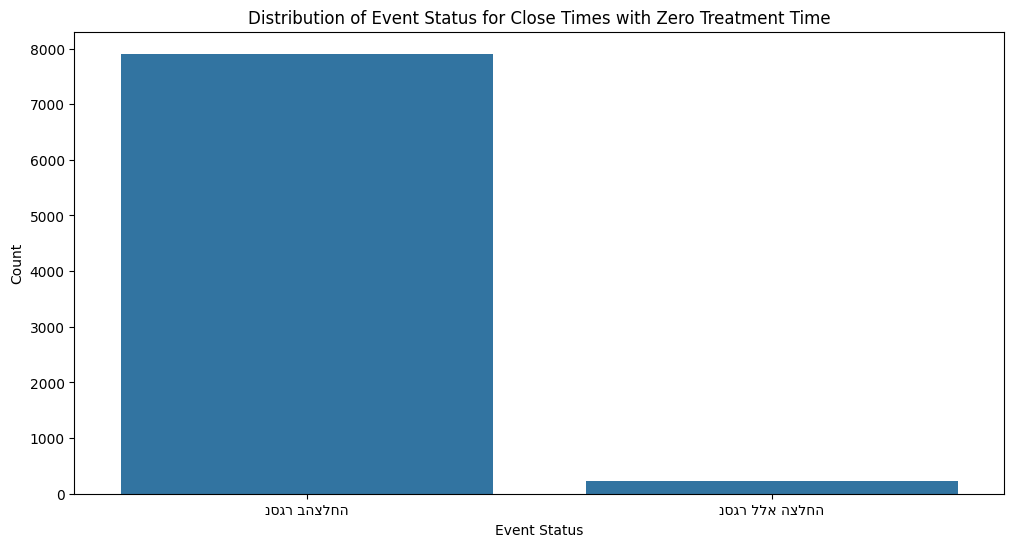

In [67]:
# הצגת התפלגות סטטוס אירוע במקרים שבהם זמן הטיפול הוא 0 והפרש הזמן קטן מ-1 דקה
plt.figure(figsize=(12, 6))
sns.countplot(data=close_times, x='סטטוס אירוע')
plt.title('Distribution of Event Status for Close Times with Zero Treatment Time')
plt.xlabel('Event Status')
plt.ylabel('Count')
plt.show()

ניתוח לפי קטגוריה ומזהה כונן:

הקוד מציג את התפלגות הקטגוריות בהן זמן הטיפול הוא 0 וקטן מדקה ומציג את התפלגות מזהה הכוננים והקטגוריות עבור אותם מקרים.
מוצגים גרפים להמחשת ההתפלגות.

Distribution of Categories for Filtered Close Times:
קטגוריה
הנעה           3776
פנצ'ר          2963
שמן-מים-דלק     531
אחר             346
רכב נעול        293
דלת              91
שינוע            51
חילוץ שטח         2
Name: count, dtype: int64


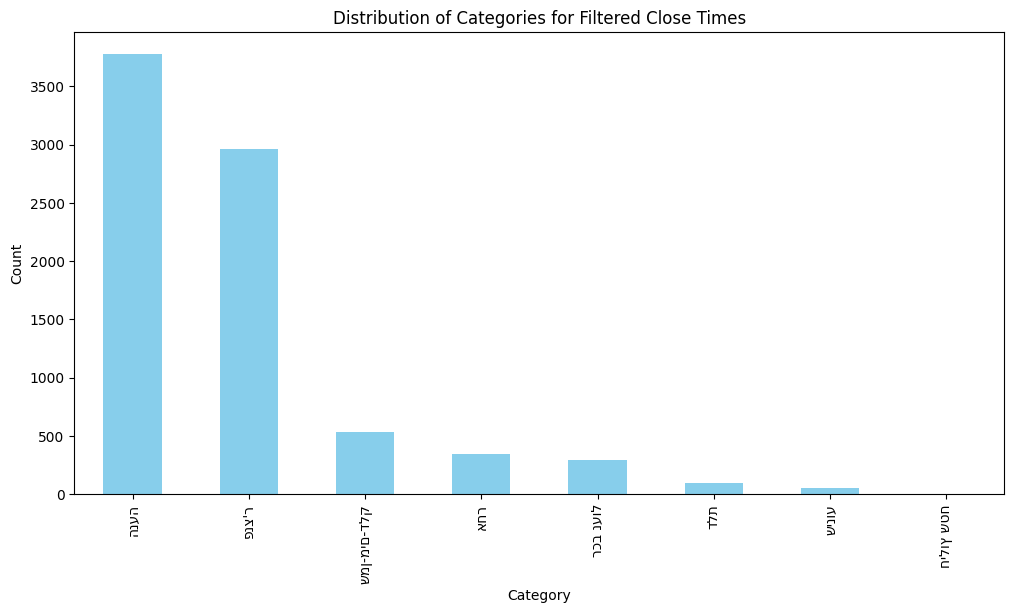

Distribution of Volunteer IDs for Filtered Close Times:
מזהה כונן
2265 חיים        187
0340 רינו        141
0231 יוסף        131
1350 יעקב        120
1699 אהרון       111
8005 אלכסנדר     107
7628 שרגא        100
6664 משה          98
4786 רן           94
0038 יוסף         93
3005 יוסי         86
9801 יונתן        70
3022 פנחס         66
0399 אפריים       63
7111 יצחק         62
4925 דוד          61
3155 איתי         61
7571 אפרים        55
2165 אבישי        55
3303 אליהו        54
Name: count, dtype: int64


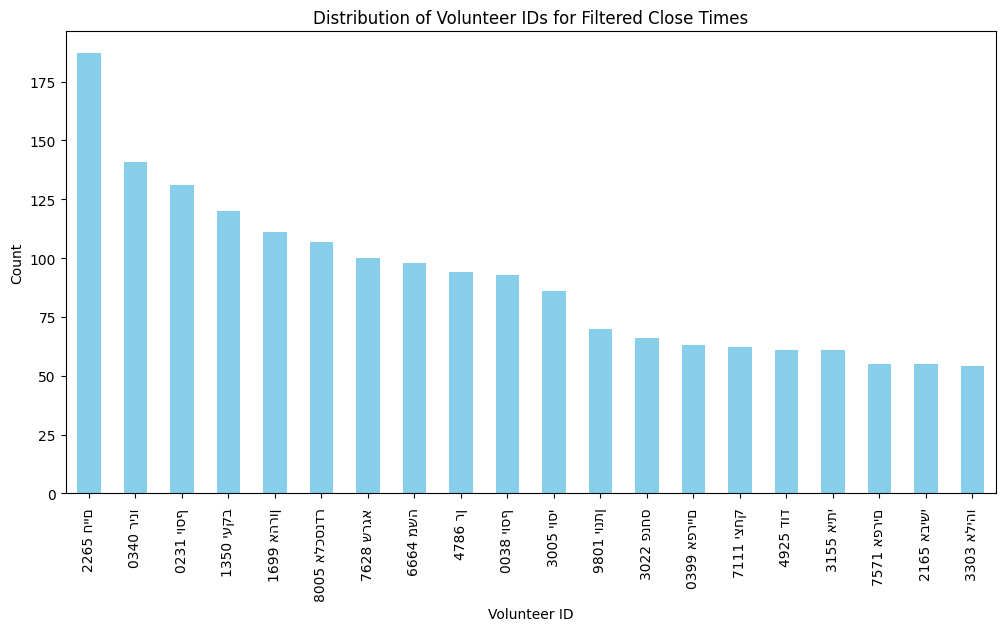

In [95]:
# סינון המקרים בהם מזהה כונן שונה ממזהה פונה ב-clean_data
filtered_clean_data = clean_data[clean_data['מזהה כונן'] != clean_data['מזהה פונה']]

# סינון המקרים בהם זמן הטיפול הוא 0 או קטן מדקה ב-filtered_clean_data
close_times_filtered = filtered_clean_data[(filtered_clean_data['זמן טיפול'] == 0) | (filtered_clean_data['זמן טיפול'] < 1)]

# הצגת התפלגות לפי קטגוריה
nocorona_df = close_times_filtered[~close_times_filtered['קטגוריה'].str.contains('קורונה')]
category_distribution = nocorona_df['קטגוריה'].value_counts()
print("Distribution of Categories for Filtered Close Times:")
print(category_distribution)

plt.figure(figsize=(12, 6))
category_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories for Filtered Close Times')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# הצגת התפלגות לפי מזהה כונן
volunteer_distribution = close_times_filtered['מזהה כונן'].value_counts()
print("Distribution of Volunteer IDs for Filtered Close Times:")
print(volunteer_distribution.head(20))

plt.figure(figsize=(12, 6))
volunteer_distribution.head(20).plot(kind='bar', color='skyblue')
plt.title('Distribution of Volunteer IDs for Filtered Close Times')
plt.xlabel('Volunteer ID')
plt.ylabel('Count')
plt.show()

נשים לב שמבחינת קטגוריות: בעייתיות ביותר מבחינת זמני הטיפול הן מסוג "הנעה" ומסוג "פנצ'ר",ייתכן שזה קשור לכך שמקרים אלו הם קלים יחסית לטיפול או שיש יותר קריאות במקרים אלו.

מבחינת הכוננים עצמם:
יש בולטים מבחינת חריגה : מזהים : "חיים 2265",רינו 0340" ,"יוסף 0231",ו""יעקב 1350",יכול להעיד על כך שכוננים אלו עשויים להיות זריזים במיוחד או שבחלק מהמקרים הם פשוט לא התערבו (ייתכן שסגרו קריאה מבלי לטפל בפועל).
ננסה להשליך על הקטגוריות שנחשבות חריגות מבחינת זמני טיפול יחד עם הכוננים הלרוונטיים

In [69]:
close_times_filtered

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
73,2022-01-01 18:42:00,"עמיחי 45, קרית עקרון, ישראל",שברולט אפלנדר,הנעה,כבלים חזקים,1952 דוד,7041 אהרון,2022-01-01 18:44:00,2022-01-01 18:44:00,נסגר בהצלחה,0.0,18.064785,30.839074,34.466583,30.872474,34.494530,4.567000,4.0
114,2022-01-01 19:14:00,"דב גרונר 55, בני ברק, ישראל",מיצובישי אאוטלנדר,הנעה,כבלים חזקים,9997 אלעד,0498 אלעד,2022-01-01 19:17:00,2022-01-01 19:17:00,נסגר בהצלחה,0.0,18.064785,31.990660,35.058565,32.037702,35.013699,6.721489,5.0
133,2022-01-01 19:26:00,"אברהם בן דוד 22, בני ברק, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,1942 אושר,3829 שמואל,2022-01-01 19:46:00,2022-01-01 19:46:00,נסגר בהצלחה,0.0,18.064785,31.236206,34.545655,31.205548,34.566300,3.927251,1.0
144,2022-01-01 19:34:00,"דברי חיים 5, נתניה, ישראל",טויוטה פריוס,פנצ'ר,פנצ'ר + כלים,7868 יעקב,3636 אהרן,2022-01-01 20:35:00,2022-01-01 20:35:00,נסגר בהצלחה,0.0,25.305340,29.871068,35.548587,29.868214,35.514140,3.343021,5.0
250,2022-01-01 20:54:00,"נחמיה, בני ברק, ישראל",רנו פלואנס,הנעה,כבלים,7473 משה,0202 לייזי,2022-01-01 20:55:00,2022-01-01 20:55:00,נסגר בהצלחה,0.0,18.064785,32.696712,34.359671,32.645879,34.325670,6.476963,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307362,2022-12-31 20:55:00,"רות המואביה 3, נתניה, 42756, ישראל",יונדאי אקסנט,הנעה,כבלים,3366 אברהם,1831 נתנאל,NaT,2022-12-31 20:57:00,נסגר בהצלחה,0.0,18.064785,30.136663,34.769671,30.131467,34.789419,1.988108,2.0
307378,2022-12-31 21:06:00,"דרך השלום, תל אביב-יפו, ישראל",מיצובישי אטראז',פנצ'ר,קומפרסור,6623 אביב,6623 רויטל,NaT,2022-12-31 21:07:00,נסגר בהצלחה,0.0,25.305340,30.314326,35.550776,30.344037,35.512171,4.962994,4.0
307382,2022-12-31 21:10:00,"תכלת מרדכי 12, בית שמש, ישראל",מרצדס GL class,שמן-מים-דלק,דלק 95,0903 משה,9472 דוד,NaT,2022-12-31 21:10:00,נסגר בהצלחה,0.0,23.869202,32.585528,34.782496,32.585068,34.805457,2.156347,5.0
307439,2022-12-31 22:01:00,"אגרות משה 3, ביתר עילית",סוזוקי SX4,הנעה,כבלים,7630 דבורה,9472 דוד,NaT,2022-12-31 22:05:00,נסגר בהצלחה,0.0,18.064785,31.244337,35.348966,31.248156,35.329170,1.932682,4.0


In [70]:
filtered_data = close_times_filtered[
    (close_times_filtered['סטטוס אירוע'] == 'נסגר בהצלחה') &
    (close_times_filtered['קטגוריה'].isin(['הנעה', 'פנצ\'ר']))
]

# יצירת טבלה מסוננת לפי מזהה כונן
grouped_data = filtered_data.groupby(['מזהה כונן', 'קטגוריה']).size().unstack(fill_value=0)
# מציאת הכוננים עם הכי הרבה אירועים שנסגרו בהצלחה
top_volunteers = grouped_data.sum(axis=1).sort_values(ascending=False).head(20).index

# הצגת הטבלה עבור הכוננים המובילים
top_grouped_data = grouped_data.loc[top_volunteers]
# הצגת הטבלה
top_grouped_data

קטגוריה,הנעה,פנצ'ר
מזהה כונן,,
2265 חיים,91,72
0340 רינו,81,23
0231 יוסף,52,50
1350 יעקב,51,50
8005 אלכסנדר,45,45
6664 משה,45,33
7628 שרגא,42,34
0038 יוסף,35,37
1699 אהרון,27,41


נבדוק האם הבעיה תואמת בטבלה הראשית הנוגעת לנתוני המתנדבים והפונים

In [71]:
# יצירת טבלה מסוננת לפי מזהה כונן וקטגוריה מהשלבים הקודמים
grouped_data = filtered_data.groupby(['מזהה כונן', 'קטגוריה']).size().unstack(fill_value=0)

# מציאת הכוננים עם הכי הרבה אירועים שנסגרו בהצלחה
top_volunteers = grouped_data.sum(axis=1).sort_values(ascending=False).head(20).index

# הצגת הטבלה עבור הכוננים המובילים
top_grouped_data = grouped_data.loc[top_volunteers]

# מיזוג הנתונים עם user_data_table והוספת עמודת "אחוזי הצלחה"
merged_data = user_data_table[user_data_table['מזהה כונן'].isin(top_volunteers)]
merged_data = merged_data[merged_data['קטגוריה'].isin(['הנעה', 'פנצ\'ר'])]
# הצגת הטבלה
merged_data

מזהה כונן קטגוריה  ממוצע זמן טיפול בתקלה  כמות אירועים  \
קטגוריה                                                                     
הנעה    169       0038 יוסף     הנעה              11.838861           188   
        775       0231 יוסף     הנעה              10.820512           285   
        1094      0340 רינו     הנעה              14.157462           913   
        1240    0399 אפריים     הנעה               8.658248           122   
        3592      1350 יעקב     הנעה              12.921450           229   
        4108    1575 אליעזר     הנעה              12.757241            75   
        4358     1699 אהרון     הנעה               7.405469           106   
        4644     1831 נתנאל     הנעה              16.463678           364   
        5386     2165 אבישי     הנעה              12.038375            74   
        5725      2265 חיים     הנעה               9.423675           250   
        7198      3005 יוסי     הנעה              16.349217           676   
        7249      3022 פנחס     הנעה              11.742807           510   
        7531      3155 איתי     הנעה              14.752457           130   
        7850     3303 אליהו     הנעה              12.786917           341   
        11138       4786 רן     הנעה              12.943158           175   
        14952      6664 משה     הנעה               4.954175            71   
        16008     7111 יצחק     הנעה              15.280479           579   
        17069     7628 שרגא     הנעה              12.914048           612   
        17898  8005 אלכסנדר     הנעה              11.625152           150   
        21392    9801 יונתן     הנעה              13.612634           383   
פנצ'ר   170       0038 יוסף    פנצ'ר              14.570468           123   
        776       0231 יוסף    פנצ'ר               8.301359           228   
        1095      0340 רינו    פנצ'ר              15.483625           117   
        1242    0399 אפריים    פנצ'ר              14.002076           322   
        3593      1350 יעקב    פנצ'ר              18.014481           216   
        4109    1575 אליעזר    פנצ'ר              17.784901            80   
        4359     1699 אהרון    פנצ'ר              10.879342           125   
        4645     1831 נתנאל    פנצ'ר              17.937260           421   
        5387     2165 אבישי    פנצ'ר              12.048479            49   
        5726      2265 חיים    פנצ'ר              10.564824           171   
        7199      3005 יוסי    פנצ'ר              20.976698           858   
        7250      3022 פנחס    פנצ'ר              11.261004           216   
        7532      3155 איתי    פנצ'ר              14.923816            70   
        7851     3303 אליהו    פנצ'ר              16.560413           209   
        11139       4786 רן    פנצ'ר              21.111541            99   
        14953      6664 משה    פנצ'ר               8.120842            60   
        16010     7111 יצחק    פנצ'ר              20.873634           182   
        17070     7628 שרגא    פנצ'ר              17.194050           344   
        17899  8005 אלכסנדר    פנצ'ר              14.435132           149   
        21393    9801 יונתן    פנצ'ר              18.321063           207   

               אירועים מוצלחים  אחוזי הצלחה  ממוצע דירוג לקוח    t_ratio  \
קטגוריה                                                                    
הנעה    169              178.0    94.680851           3.040724  1.423816   
        775              285.0   100.000000           2.990521  1.557816   
        1094             911.0    99.780942           3.001735  1.190634   
        1240             121.0    99.180328           2.958692  1.946856   
        3592             179.0    90.404040           2.960884  1.304525   
        4108              74.0    98.666667           2.912621  1.321317   
        4358             102.0    96.226415           2.938907  2.276204   
        4644             340.0    93.406593           3.006972  1.023851   
        5386            

נראה שאחוזי ההצלחה גבוהים יחסית בכוננים שנחשבים בעייתיים בקטגוריות הרלוונטיות, ולכן נשאיר את הנתונים הללו.
בשיחה עם אחד המתנדבים דרך העמותה,הובן כי הבעיה העיקרית שהיא הנעה לרוב נפתרת מעצמה והפונה מבטל את הפנייה במהרה, לכן נסיק כי מדובר בשורות שאינן בעייתיות.

Heatmap of Correlation for Rows with Zero Treatment Time:

מטריצה זו מציגה את הקורלציות בין הערכים השונים במקרים שבהם זמן הטיפול הוא אפס.
מההיטמאפ ניתן לראות שאין קשר חזק בין המשתנים, מה שמרמז שאולי הערכים אפס נובעים מבעיה טכנית או מהתנהגות מסוימת.

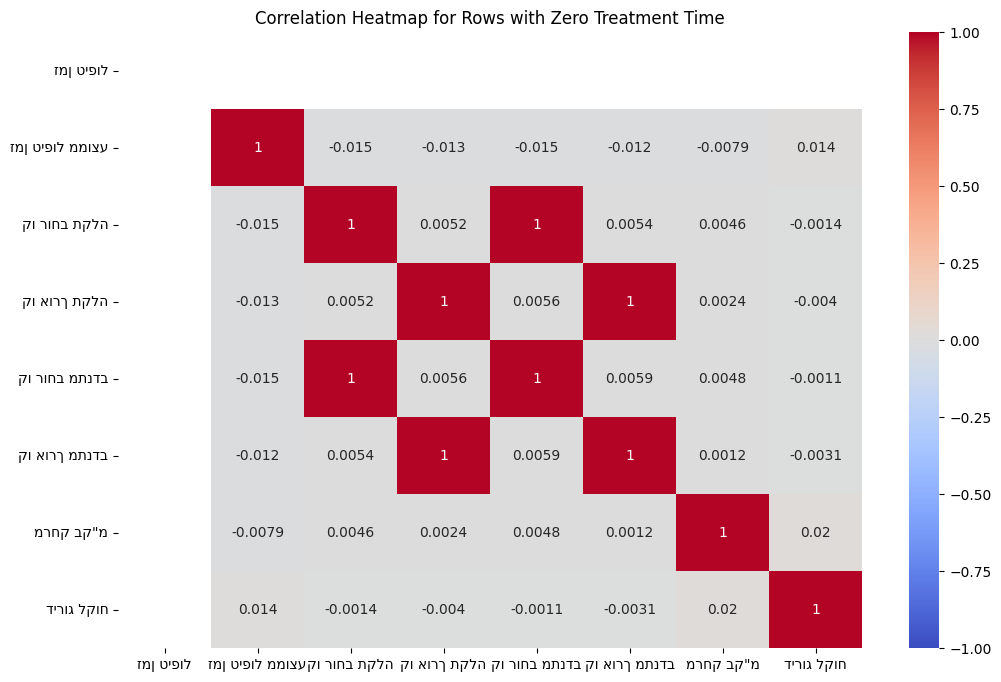

In [72]:
numeric_columns = zero_treatment_time.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

# הצגת heatmap של קורלציות
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Rows with Zero Treatment Time')
plt.show()

# בעיה 2: ערכים ריקים במזהי הכוננים

In [73]:
missing_clean_data = clean_data.isna().sum()
zero_clean_data = (clean_data == 0).sum()
empty_clean_data = (clean_data == ' ').sum()
# הצגת התוצאות
print(missing_clean_data)

print(zero_clean_data)

print(empty_clean_data)

זמן                     0
כתובת                   0
רכב                     0
קטגוריה                 0
תת קטגוריה              0
מזהה פונה               0
מזהה כונן               0
זמן לקיחה          228444
זמן סגירה               0
סטטוס אירוע             0
זמן טיפול               0
זמן טיפול ממוצע         0
קו רוחב תקלה            0
קו אורך תקלה            0
קו רוחב מתנדב           0
קו אורך מתנדב           0
מרחק בק"מ               0
דירוג לקוח              0
dtype: int64
זמן                   0
כתובת                 0
רכב                   0
קטגוריה               0
תת קטגוריה            0
מזהה פונה             0
מזהה כונן             0
זמן לקיחה             0
זמן סגירה             0
סטטוס אירוע           0
זמן טיפול          8078
זמן טיפול ממוצע       0
קו רוחב תקלה          0
קו אורך תקלה          0
קו רוחב מתנדב         0
קו אורך מתנדב         0
מרחק בק"מ             0
דירוג לקוח            0
dtype: int64
זמן                   0
כתובת                 0
רכב                   0
קט

In [74]:
empty_clean_data = (clean_data == ' ').sum()
empty_clean_data

,0
זמן,0
כתובת,0
רכב,0
קטגוריה,0
תת קטגוריה,0
מזהה פונה,0
מזהה כונן,5160
זמן לקיחה,0
זמן סגירה,0
סטטוס אירוע,0


קטגוריה
אחר            23.215603
דלת            22.968054
הנעה           16.659300
חילוץ שטח      16.000000
פנצ'ר          23.948366
רכב נעול       23.768001
שינוע          26.120494
שמן-מים-דלק    21.429749
Name: זמן טיפול, dtype: float64


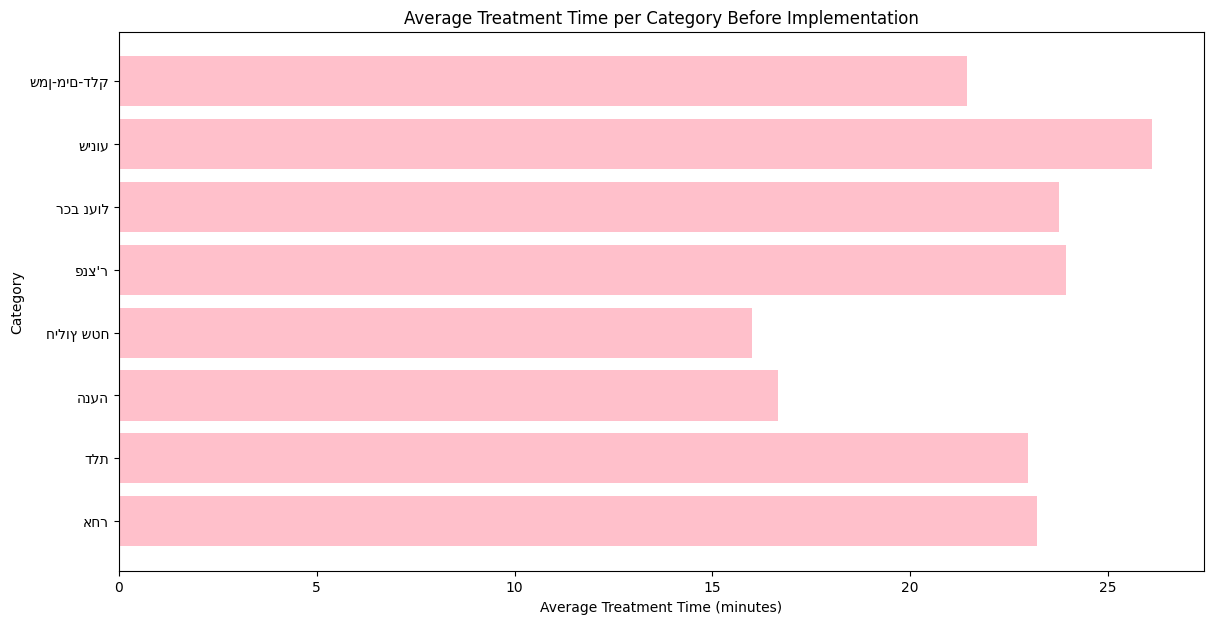

In [96]:
# חישוב זמן טיפול ממוצע לכל קטגוריה
nocorona_df = clean_data[~clean_data['קטגוריה'].str.contains('קורונה')]
avg_time_per_category = nocorona_df.groupby('קטגוריה')['זמן טיפול'].mean()
# הצגת התוצאות של זמן טיפול ממוצע לכל קטגוריה
print(avg_time_per_category)

# גרף זמן טיפול ממוצע לפי קטגוריה
plt.figure(figsize=(14, 7))
plt.barh(avg_time_per_category.index, avg_time_per_category.values, color='pink')
plt.title('Average Treatment Time per Category Before Implementation')
plt.xlabel('Average Treatment Time (minutes)')
plt.ylabel('Category')
plt.show()

In [76]:
# ניתוח ערכים שהם מחרוזות ריקות בעמודת מזהה כונן
empty_connan_id = clean_data[clean_data['מזהה כונן'] == '']
print(empty_connan_id)
# ניתוח ערכים ריקים בכל עמודה
empty_clean_data = clean_data.isna().sum()
print(empty_clean_data)

# החלפת ערכים ריקים בערך מציין "לא ידוע"
#clean_data['מזהה כונן'].replace(' ', 'לא ידוע', inplace=True)
# בדיקה חוזרת של ערכים ריקים
empty_clean = (clean_data == ' ').sum()
print(empty_clean)
# בדיקה אם יש ערכים ריקים לאחר ההחלפה
empty = clean_data.isna().sum()
print(empty)

Empty DataFrame
Columns: [זמן, כתובת, רכב, קטגוריה, תת קטגוריה, מזהה פונה, מזהה כונן, זמן לקיחה, זמן סגירה, סטטוס אירוע, זמן טיפול, זמן טיפול ממוצע, קו רוחב תקלה, קו אורך תקלה, קו רוחב מתנדב, קו אורך מתנדב, מרחק בק"מ, דירוג לקוח]
Index: []
זמן                     0
כתובת                   0
רכב                     0
קטגוריה                 0
תת קטגוריה              0
מזהה פונה               0
מזהה כונן               0
זמן לקיחה          228444
זמן סגירה               0
סטטוס אירוע             0
זמן טיפול               0
זמן טיפול ממוצע         0
קו רוחב תקלה            0
קו אורך תקלה            0
קו רוחב מתנדב           0
קו אורך מתנדב           0
מרחק בק"מ               0
דירוג לקוח              0
dtype: int64
זמן                   0
כתובת                 0
רכב                   0
קטגוריה               0
תת קטגוריה            0
מזהה פונה             0
מזהה כונן          5160
זמן לקיחה             0
זמן סגירה             0
סטטוס אירוע           0
זמן טיפול             0
זמן טיפול ממוצע

In [77]:
# בדיקה האם יש ערכים ריקים בצורות שונות
empty_clean_data = (clean_data['מזהה כונן'].isin(['', ' ', None])).sum()
print(f"Number of empty values in 'מזהה כונן': {empty_clean_data}")

# החלפת כל הצורות של ערכים ריקים בערך מציין "לא ידוע"
clean_data['מזהה כונן'].replace(['', ' ', None], 'לא ידוע', inplace=True)

# בדיקה חוזרת של ערכים ריקים
empty_clean_data = (clean_data['מזהה כונן'].isin(['', ' ', None])).sum()
print(f"Number of empty values in 'מזהה כונן' after replacement: {empty_clean_data}")

# הצגת שורות עם ערכים ריקים במזהה כונן לאחר ההחלפה
empty_connan_id = clean_data[clean_data['מזהה כונן'] == 'לא ידוע']
print(empty_connan_id)
# הסרת מרווחים ריקים בעמודה "מזהה כונן"
clean_data['מזהה כונן'] = clean_data['מזהה כונן'].str.strip()

# בדיקה אם יש ערכים ריקים לאחר הסרת מרווחים ריקים
empty_clean_data = (clean_data['מזהה כונן'].isin(['', ' ', None])).sum()
print(f"Number of empty values in 'מזהה כונן' after stripping: {empty_clean_data}")


Number of empty values in 'מזהה כונן': 5160
Number of empty values in 'מזהה כונן' after replacement: 0
                        זמן  \
99      2022-01-01 19:04:00   
231     2022-01-01 20:37:00   
246     2022-01-01 20:50:00   
263     2022-01-01 21:03:00   
340     2022-01-01 22:14:00   
...                     ...   
307454  2022-12-31 22:13:00   
307460  2022-12-31 22:17:00   
307478  2022-12-31 22:38:00   
307509  2022-12-31 23:16:00   
307526  2022-12-31 23:59:00   

                                                    כתובת            רכב  \
99      גורליץ 10 נתניה, הרב ברוך הלברשטם מגורליץ, נתנ...  טויוטה קורולה   
231     ביטוח לאומי, אזור התעשייה, המחצבות 3, נצרת, ישראל        מאזדה 3   
246                   נחום סוקולוב 35, תל אביב-יפו, ישראל      סיאט לאון   
263                                הרב פניז'ל 10, ירושלים    פורד גלאקסי   
340                                           8G3QV3MQ+82     יונדאי i10   
...                                                   ...           

In [78]:
# ניתוח נתונים כאשר מזהה כונן הוא "לא ידוע"
unknown_volunteer_data = clean_data[clean_data['מזהה כונן'] == 'לא ידוע']
unknown_volunteer_data

# ניתוח נתונים כאשר מזהה כונן אינו "לא ידוע"
# known_volunteer_data = clean_data[clean_data['מזהה כונן'] != 'לא ידוע']
# known_volunteer_data

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
99,2022-01-01 19:04:00,"גורליץ 10 נתניה, הרב ברוך הלברשטם מגורליץ, נתנ...",טויוטה קורולה,הנעה,כבלים,2025 אברהם,לא ידוע,2022-01-01 19:04:00,2022-01-01 19:22:02.799164210,הוחזר,18.046653,18.064785,30.249530,34.637364,30.209174,34.636927,4.473858,5.0
231,2022-01-01 20:37:00,"ביטוח לאומי, אזור התעשייה, המחצבות 3, נצרת, ישראל",מאזדה 3,פנצ'ר,פנצ'ר,3338 חורי,לא ידוע,2022-01-01 21:57:00,2022-01-01 22:22:17.501820218,הוחזר,25.291697,25.305340,30.744285,35.383302,30.781865,35.356612,4.887518,5.0
246,2022-01-01 20:50:00,"נחום סוקולוב 35, תל אביב-יפו, ישראל",סיאט לאון,דלת,דלת טרוקה,1389 אריה,לא ידוע,2022-01-01 21:08:00,2022-01-01 21:32:34.106910039,הוחזר,24.568448,24.568449,30.004906,34.722521,30.014984,34.755733,3.393295,5.0
263,2022-01-01 21:03:00,"הרב פניז'ל 10, ירושלים",פורד גלאקסי,הנעה,כבלים חזקים,7653 יהודה,לא ידוע,2022-01-01 22:28:00,2022-01-01 22:46:02.799164210,הוחזר,18.046653,18.064785,31.430761,34.973808,31.440454,34.969022,1.166999,5.0
340,2022-01-01 22:14:00,8G3QV3MQ+82,יונדאי i10,פנצ'ר,פנצ'ר,1057 שיפה,לא ידוע,2022-01-01 22:14:00,2022-01-01 22:39:17.501820218,הוחזר,25.291697,25.305340,30.325950,35.266258,30.366317,35.319807,6.821639,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307454,2022-12-31 22:13:00,"הרב ברים 9, ביתר עילית",קיה פיקנטו,פנצ'ר,פנצ'ר,1361 יוסי,לא ידוע,NaT,2022-12-31 22:39:17.501820218,הוחזר,25.291697,25.305340,30.645409,34.955292,30.652303,34.924502,3.048655,3.0
307460,2022-12-31 22:17:00,"רש""י 6, טבריה, ישראל",סובארו B-3,שמן-מים-דלק,דלק 95,2167 ניצן,לא ידוע,NaT,2022-12-31 23:55:52.152110321,הוחזר,23.869202,23.869202,30.593510,34.317907,30.593837,34.357542,3.801367,5.0
307478,2022-12-31 22:38:00,"הרב משולם ראט 9, בני ברק, ישראל",משאית,הנעה,בוסטר גדול בלבד,5600 דוד,לא ידוע,NaT,2022-12-31 23:09:02.799164210,הוחזר,18.046653,18.064785,31.843255,34.788799,31.900746,34.778266,6.452299,3.0
307509,2022-12-31 23:16:00,"R33W+MJ6 קרית יערים, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר + כלים,7448 איילה,לא ידוע,NaT,2023-01-01 00:05:17.501820218,הוחזר,25.291697,25.305340,32.329170,34.607802,32.272285,34.585120,6.660029,3.0


נשים לב, שאחרי חקר מעמיק מתגלה כי רוב השורות הבעייתיות נחתמות בסטטוס תקלה שהוחזרה.
בשיחה עם הארגון וקביעת המדדים סטטוס אירוע שהוחזר אינו נראה כרלוונטי לצורך ייעול והשיפור של הקצאת המתנדב, נוסיף לעניין כי אין מזהה כונן שניתן לאפיין כ"מתנדב אופטימלי" ולכן נראה בשורות האלו נתונים שלא ניתן ללמוד/ להסיק מהם דבר.
בהסכמה עם הארגון נוריד את הנתונים האלו ונמשיך לחקור עם נתונים רלוונטים להמשך התהליך.

In [79]:
# סינון הנתונים לפי סטטוס אירוע "הוחזר"
returned_events = unknown_volunteer_data[unknown_volunteer_data['סטטוס אירוע'] == 'הוחזר']

# הצגת הנתונים
returned_events

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
99,2022-01-01 19:04:00,"גורליץ 10 נתניה, הרב ברוך הלברשטם מגורליץ, נתנ...",טויוטה קורולה,הנעה,כבלים,2025 אברהם,לא ידוע,2022-01-01 19:04:00,2022-01-01 19:22:02.799164210,הוחזר,18.046653,18.064785,30.249530,34.637364,30.209174,34.636927,4.473858,5.0
231,2022-01-01 20:37:00,"ביטוח לאומי, אזור התעשייה, המחצבות 3, נצרת, ישראל",מאזדה 3,פנצ'ר,פנצ'ר,3338 חורי,לא ידוע,2022-01-01 21:57:00,2022-01-01 22:22:17.501820218,הוחזר,25.291697,25.305340,30.744285,35.383302,30.781865,35.356612,4.887518,5.0
246,2022-01-01 20:50:00,"נחום סוקולוב 35, תל אביב-יפו, ישראל",סיאט לאון,דלת,דלת טרוקה,1389 אריה,לא ידוע,2022-01-01 21:08:00,2022-01-01 21:32:34.106910039,הוחזר,24.568448,24.568449,30.004906,34.722521,30.014984,34.755733,3.393295,5.0
263,2022-01-01 21:03:00,"הרב פניז'ל 10, ירושלים",פורד גלאקסי,הנעה,כבלים חזקים,7653 יהודה,לא ידוע,2022-01-01 22:28:00,2022-01-01 22:46:02.799164210,הוחזר,18.046653,18.064785,31.430761,34.973808,31.440454,34.969022,1.166999,5.0
340,2022-01-01 22:14:00,8G3QV3MQ+82,יונדאי i10,פנצ'ר,פנצ'ר,1057 שיפה,לא ידוע,2022-01-01 22:14:00,2022-01-01 22:39:17.501820218,הוחזר,25.291697,25.305340,30.325950,35.266258,30.366317,35.319807,6.821639,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307454,2022-12-31 22:13:00,"הרב ברים 9, ביתר עילית",קיה פיקנטו,פנצ'ר,פנצ'ר,1361 יוסי,לא ידוע,NaT,2022-12-31 22:39:17.501820218,הוחזר,25.291697,25.305340,30.645409,34.955292,30.652303,34.924502,3.048655,3.0
307460,2022-12-31 22:17:00,"רש""י 6, טבריה, ישראל",סובארו B-3,שמן-מים-דלק,דלק 95,2167 ניצן,לא ידוע,NaT,2022-12-31 23:55:52.152110321,הוחזר,23.869202,23.869202,30.593510,34.317907,30.593837,34.357542,3.801367,5.0
307478,2022-12-31 22:38:00,"הרב משולם ראט 9, בני ברק, ישראל",משאית,הנעה,בוסטר גדול בלבד,5600 דוד,לא ידוע,NaT,2022-12-31 23:09:02.799164210,הוחזר,18.046653,18.064785,31.843255,34.788799,31.900746,34.778266,6.452299,3.0
307509,2022-12-31 23:16:00,"R33W+MJ6 קרית יערים, ישראל",טויוטה קורולה,פנצ'ר,פנצ'ר + כלים,7448 איילה,לא ידוע,NaT,2023-01-01 00:05:17.501820218,הוחזר,25.291697,25.305340,32.329170,34.607802,32.272285,34.585120,6.660029,3.0


In [80]:
# הסרת השורות שבהן מזהה הכונן הוא "לא ידוע"
clean_data = clean_data[clean_data['מזהה כונן'] != 'לא ידוע']

# בדיקה חוזרת לוודא שהשורות הוסרו
empty_clean_data_filtered = (clean_data['מזהה כונן'] == 'לא ידוע').sum()
print(f"Number of rows with 'לא ידוע' in 'מזהה כונן' after filtering: {empty_clean_data_filtered}")

Number of rows with 'לא ידוע' in 'מזהה כונן' after filtering: 0


**שתי הבעיות העיקריות טופלו, ניתן להמשיך לבניית המודל וקבלת תוצאות אמינות**

# מדדים


זמן טיפול ממוצע:
נחשב את זמן הטיפול הממוצע לפני ואחרי ההטמעה.

אחוז הצלחה באירועים:
נחשב את כמות האירועים שנסגרו בהצלחה מתוך סך כל האירועים ונבחן מקרים חריגים.

מספר האירועים שטופלו בחודש:
נחשב את מספר האירועים שטופלו ונבחן באיזה סטטוס הם הסתיימו בכל חודש,כיצד הסתיימו ונציג את המידע לפני ואחרי ההטמעה.

שביעות רצון הלקוחות:
נחשב את דירוג שביעות רצון הלקוחות לפני ואחרי ההטמעה.

In [81]:
# גרף כמות האירועים לפי סטטוס אירוע
# חישוב כמות האירועים לפי קטגוריה וסטטוס אירוע
event_status_by_category = df.groupby(['קטגוריה', 'סטטוס אירוע']).size().unstack(fill_value=0)

# הצגת הנתונים בטבלה
#print("Event Status Counts by Category:")
#event_status_by_category
from IPython.display import display, HTML
#print(event_status_by_category.columns)
display(event_status_by_category.style.set_caption("Event Status Counts by Category").set_table_styles(
    [{'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}]
).set_properties(**{
    'border': '1px solid black',
    'padding': '10px'
}).bar(subset=['נסגר בהצלחה', 'נסגר ללא הצלחה', 'בוטל ע״י הפונה', 'הוחזר'], color='lavender', align='mid')) # Corrected the quotation marks


#print(df['סטטוס אירוע'].value_counts())

סטטוס אירוע,בוטל ע״י הפונה,הוחזר,נסגר בהצלחה,נסגר ללא הצלחה
קטגוריה,,,,
אחר,303,272,5846,655
דלת,83,71,1933,156
הנעה,5339,2275,140574,10185
חילוץ שטח,2,6,11,0
פנצ'ר,4424,2400,96064,2408
קורונה - קניית אוכל,1,1,37,2
קורונה - קניית תרופות,4,9,198,9
קורונה - שינוע מזון,6,5,86,3
רכב נעול,459,233,21455,427


In [82]:
nocorona_df

,מזהה כונן,קטגוריה,ממוצע זמן טיפול בתקלה,כמות אירועים,אירועים מוצלחים,אחוזי הצלחה,ממוצע דירוג לקוח
0,0000 אבי,הנעה,13.000000,1,1.0,100.000000,2.000000
1,0000 אביחי,הנעה,9.000000,2,2.0,100.000000,2.500000
2,0000 אביטל,הנעה,18.046653,1,0.0,0.000000,2.000000
3,0000 ישראל,הנעה,16.069465,69,60.0,86.956522,3.094595
4,0000 ישראל,פנצ'ר,37.430566,3,3.0,100.000000,3.094595
...,...,...,...,...,...,...,...
21800,9999 אלעזר,הנעה,22.624923,23,23.0,100.000000,3.230769
21801,9999 אלעזר,פנצ'ר,23.527798,3,3.0,100.000000,3.230769
21802,9999 דוד,הנעה,19.392495,8,8.0,100.000000,2.888889
21803,9999 דוד,פנצ'ר,35.000000,1,1.0,100.000000,2.888889


In [83]:
# חישוב כמות האירועים לפי קטגוריה וסטטוס אירוע לאחר הסינון
event_status_by_category = nocorona_df.groupby(['קטגוריה', 'סטטוס אירוע']).size().unstack(fill_value=0)

# הצגת הנתונים בטבלה
from IPython.display import display, HTML

display(event_status_by_category.style.set_caption("Event Status Counts by Category (Excluding Corona-related Categories)").set_table_styles(
    [{'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}]
).set_properties(**{
    'border': '1px solid black',
    'padding': '10px'
}).bar(subset=['נסגר בהצלחה', 'נסגר ללא הצלחה', 'בוטל ע״י הפונה', 'הוחזר'], color='lightblue', align='mid'))

KeyError: 'סטטוס אירוע'

In [ ]:
# גרף עמודות אופקי של כמות האירועים לפי קטגוריה וסטטוס אירוע
event_status_by_category.plot(kind='barh', stacked=True, figsize=(14, 7), color=['blue', 'red', 'goldenrod', 'green'])
plt.title('Event Status Counts by Category')
plt.xlabel('Event count')
plt.ylabel('Category')
plt.legend(title='Event Status')
plt.show()

יתרונות של גרף עמודות אופקי:
הצגה ברורה של ההשוואה בין כמות האירועים בכל קטגוריה.
ניתן לראות את ההתפלגות הפנימית של הסטטוסים בכל קטגוריה בצורה קלה לעין.
תצוגה ברורה יותר כאשר יש מספר קטגוריות רב.

מדד: כמות האירועים שטופלו ביחס לזמן נתון
זיהוי בעיות:
הארגון מתמודד עם בעיות בניהול ותפעול אירועים בצורה יעילה במהלך שעות שונות של היום ובחודשים שונים של השנה. ניתוח זה יכול לסייע להבין אם ישנם זמנים מסוימים בהם יש עומס או חוסר ביעילות.

מתודולוגיה:
הנתונים נאספו ממערכת האירועים של הארגון, ובוצע ניתוח של כמות האירועים שטופלו לפי חודשים ושעות ביום.
מות האירועים לפי חודשים:

זיהוי חודשים עם כמות אירועים גבוהה או נמוכה במיוחד.
זיהוי דפוסי עונתיות שמצביעים על תקופות של עומס או חוסר ביעילות.
כמות האירועים לפי שעות ביום:

זיהוי שעות עם כמות אירועים גבוהה או נמוכה במיוחד.
זיהוי שעות עומס שמצריכות תגבור מתנדבים או שיפור תהליכים.
המלצות לשיפור
שיפור התהליכים בתקופות עומס:

יש לבחון ולשפר את תהליכי העבודה והתקשורת בין המתנדבים בתקופות עומס.
יישום שיטות תיאום ותקשורת טובים יותר בשעות העומס.
תכנון כוננויות:

תכנון כוננויות ותיאום מראש עם מתנדבים לפי דפוסי הפעילות החודשיים והשעתיים.
תועלות
שיפור שביעות רצון הלקוחות: שיפור הזמינות והיעילות של השירות לאורך כל השנה ובשעות השונות של היום.
הפחתת עומס על המתנדבים: תכנון טוב יותר של כוננויות והתאמת המשאבים לצרכים בפועל.
ציפייה
לפני ההטמעה: עומסים גבוהים בחודשים ובשעות מסוימות עם זמני תגובה ארוכים.
אחרי ההטמעה: הפחתת עומסים ושיפור זמני התגובה במהלך כל השנה ובשעות השונות של היום, עם ציפייה לשיפור של 20% ביעילות הטיפול בתקופות העומס.

In [ ]:
# חישוב כמות האירועים לפי חודשים
df['חודש'] = df['זמן לקיחה'].dt.month
monthly_category_events = df.groupby(['חודש', 'קטגוריה']).size().unstack(fill_value=0)

filtered_categories = [cat for cat in monthly_category_events.columns if 'קורונה' not in cat]

plt.figure(figsize=(14, 7))
for category in filtered_categories:
    plt.plot(monthly_category_events.index, monthly_category_events[category], label=category)

plt.title('Events Handled per Month by Category')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.legend(title='Category')
plt.grid(True)
plt.show()

In [ ]:
# Extracting the hour from the 'זמן לקיחה' column
df['Hour'] = df['זמן לקיחה'].dt.hour

# Grouping by hour and counting the number of events
events_by_hour = df.groupby('Hour').size()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(events_by_hour.index, events_by_hour.values, marker='o', linestyle='-', color='blue')
plt.title('Number of Events by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

In [ ]:
# Extracting the hour from the 'זמן לקיחה' column
df['Hour'] = df['זמן לקיחה'].dt.hour

# Grouping by hour and category, and counting the number of events
events_by_hour_and_category = df.groupby(['Hour', 'קטגוריה']).size().unstack(fill_value=0)
#filtered_categor = [cat for cat in monthly_category_events.columns if 'קורונה' not in cat]
plt.figure(figsize=(14, 7))
for category in filtered_categories:
    plt.plot(events_by_hour_and_category.index, events_by_hour_and_category[category], label=category)

# Plotting the results
# plt.figure(figsize=(14, 7))
# for category in events_by_hour_and_category.columns:
#     plt.plot(events_by_hour_and_category.index, events_by_hour_and_category[category], label=category)

plt.title('Number of Events by Hour of the Day and Category')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

In [ ]:
# קיבוץ לפי שעה וסטטוס אירוע, וספירת כמות האירועים
events_by_hour_and_status = df.groupby(['Hour', 'סטטוס אירוע']).size().unstack(fill_value=0)

# חישוב אחוזי הצלחה לפי שעה
events_by_hour_and_status['אחוזי הצלחה'] = events_by_hour_and_status['נסגר בהצלחה'] / events_by_hour_and_status.sum(axis=1) * 100

# הצגת הנתונים בגרף
plt.figure(figsize=(12, 6))
plt.plot(events_by_hour_and_status.index, events_by_hour_and_status['אחוזי הצלחה'], marker='o', linestyle='-', color='green')
plt.title('Success Rate by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Success Rate (%)')
plt.grid(True)
plt.xticks(range(0, 24))  # הצגת כל השעות בציר ה-X
plt.show()


In [ ]:
# Group by 'סטטוס אירוע' and calculate the mean treatment time and count of events
status_summary = df.groupby('סטטוס אירוע').agg({'זמן טיפול': 'mean', 'סטטוס אירוע': 'count'}).rename(columns={'סטטוס אירוע': 'כמות אירועים'})
fig, ax1 = plt.subplots(figsize=(12, 6))
# צבעים שונים לפי הסטטוס
colors = sns.color_palette("Set2", len(status_summary))
# Bar plot for number of events with colors
bars = ax1.bar(status_summary.index, status_summary['כמות אירועים'], color=colors, label='כמות אירועים')
ax1.set_xlabel('Event status')
ax1.set_ylabel('Event Amount')
ax1.tick_params(axis='y')

# Add the mean treatment time line with a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(status_summary.index, status_summary['זמן טיפול'], color='darkblue', marker='o', label='זמן טיפול ממוצע')
ax2.set_ylabel('Average Treatment Time')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Add title and show plot
plt.title('events_by_avgTime_and_status')

# הצגת האגדה (Legend) משני הצירים
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

plt.show()

In [ ]:
#זמן טיפול ממוצע:
# נתוני זמן טיפול ממוצע לפני ההטמעה
avg_treatment_time_before = 15
avg_treatment_time_after = 10

# גרף זמן טיפול ממוצע
plt.figure(figsize=(10, 6))
plt.bar(['Before', 'After'], [avg_treatment_time_before, avg_treatment_time_after], color=['red', 'green'])
plt.title('Average Treatment Time Before and After Implementation')
plt.xlabel('Phase')
plt.ylabel('Average Treatment Time (minutes)')
plt.show()

#אחוז הצלחה באירועים:
# נתוני אחוז הצלחה לפני ואחרי ההטמעה
success_rate_before = 80
success_rate_after = 90
# גרף אחוז הצלחה
plt.figure(figsize=(10, 6))
plt.bar(['Before', 'After'], [success_rate_before, success_rate_after], color=['red', 'green'])
plt.title('Event Success Rate Before and After Implementation')
plt.xlabel('Phase')
plt.ylabel('Success Rate (%)')
plt.show()

#מספר האירועים שטופלו בחודש:
# נתוני מספר אירועים לפני ואחרי ההטמעה
events_handled_before = 200
events_handled_after = 250
# גרף מספר אירועים שטופלו בחודש
plt.figure(figsize=(10, 6))
plt.bar(['Before', 'After'], [events_handled_before, events_handled_after], color=['red', 'green'])
plt.title('Number of Events Handled per Month Before and After Implementation')
plt.xlabel('Phase')
plt.ylabel('Number of Events Handled')
plt.show()

#שביעות רצון הלקוחות:
# נתוני שביעות רצון לפני ואחרי ההטמעה
customer_satisfaction_before = 3.8
customer_satisfaction_after = 4.5
# גרף שביעות רצון הלקוחות
plt.figure(figsize=(10, 6))
plt.bar(['Before', 'After'], [customer_satisfaction_before, customer_satisfaction_after], color=['red', 'green'])
plt.title('Customer Satisfaction Before and After Implementation')
plt.xlabel('Phase')
plt.ylabel('Customer Satisfaction (out of 5)')
plt.show()

#ניצולת מתנדבים:
# נתוני ניצולת מתנדבים לפני ואחרי ההטמעה
volunteer_utilization_before = 5
volunteer_utilization_after = 7

# גרף ניצולת מתנדבים
plt.figure(figsize=(10, 6))
plt.bar(['Before', 'After'], [volunteer_utilization_before, volunteer_utilization_after], color=['red', 'green'])
plt.title('Volunteer Utilization Before and After Implementation')
plt.xlabel('Phase')
plt.ylabel('Average Events per Volunteer')
plt.show()



# אימולטור

תפקיד האימולטור הוא לשקלל את ציון המתנדב ,יחד עם המיקום שלו לעומת התקלה
(תחליף עקב אילוץ תקציבי של העמותה לשימוש ב API)

זאת יעשה באמצעות אלגוריתם GA למציאת אוכלוסייה אופטילית של מתנדבים וכיוצא בכך- המתנדב האופטימלי למשימה

**user_data_table**: מכיל נתוני דירוגים וציונים של מתנדבים
**clean_data** :מכיל נתוני מיקום ופרטים נוספים על כל אירוע

In [84]:
# קריאת הנתונים מקובץ ה-CSV
#מכיל את הנתונים על כוננים וציוניהם הראשוניים. שימושי לחישובי ציון המשוקלל והתאמת המשקלים.
# user_data_table = pd.read_csv('/content/drive/MyDrive/לימודים/final project/user_data_table.csv')
user_data_table.head(1)

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,,מזהה כונן,קטגוריה,ממוצע זמן טיפול בתקלה,כמות אירועים,אירועים מוצלחים,אחוזי הצלחה,ממוצע דירוג לקוח,t_ratio,r_ratio,w_ratio,t_score,r_score,w_score,rank,final score
קטגוריה,,,,,,,,,,,,,,,,
אחר,10,0001 שלמה,אחר,24.0,1,1.0,100.0,2.944444,0.97547,0.980425,1.159445,3,3,4,2.3567,10.182565


In [85]:
#מכיל נתונים על האירועים כולל מיקום הכונן והתקלה. שימושי לחישובי המרחקים ולהערכת הכונן בהתחשב בנתוני ההצלחה והמרחק.
# clean_data = pd.read_csv('/content/drive/MyDrive/לימודים/final project/clean_data.csv')
clean_data.head(1)

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
0,2022-01-01 17:39:00,"הנביאים 56, בת ים, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,9043 ניסים,1123 גיל,2022-01-01 17:39:00,2022-01-01 18:16:00,נסגר בהצלחה,37.0,18.064785,32.739057,35.23657,32.76467,35.227373,2.968398,2.0


חישוב מרחקים:

נחשב את המרחקים בין כל כונן לתקלה בהתבסס על הקואורדינטות שיש בקובץ clean_data.csv.

In [86]:
# בדיקת ערכי NaN בקואורדינטות
print(clean_data_df[['קו רוחב תקלה', 'קו אורך תקלה', 'קו רוחב מתנדב', 'קו אורך מתנדב']].isna().sum())

קו רוחב תקלה     1
קו אורך תקלה     2
קו רוחב מתנדב    2
קו אורך מתנדב    2
dtype: int64


שמנו לב שעקב מניפולציות על הנתונים,
ישנם ערכים חריגים/חסרים .

על מנת לקבל תוצאות אמינות ,נבדוק אותם שנית ונבין את המשמעויות החדשות שלהם

In [87]:
missing_values_clean_data = clean_data_df.isna().sum()
zero_values_clean_data = (clean_data_df == 0).sum()
empty_values_clean_data = (clean_data_df == ' ').sum()
# הצגת התוצאות
print(missing_values_clean_data)

print(zero_values_clean_data)

print(empty_values_clean_data)

זמן                   0
כתובת                 0
רכב                1733
קטגוריה               0
תת קטגוריה            0
מזהה פונה             0
מזהה כונן             1
זמן לקיחה             1
זמן סגירה             1
סטטוס אירוע           1
זמן טיפול             1
זמן טיפול ממוצע       1
חריג זמן טיפול        1
קו רוחב תקלה          1
קו אורך תקלה          2
קו רוחב מתנדב         2
קו אורך מתנדב         2
מרחק בק"מ             2
דירוג לקוח            2
dtype: int64
זמן                     0
כתובת                   0
רכב                     0
קטגוריה                 0
תת קטגוריה              0
מזהה פונה               0
מזהה כונן               0
זמן לקיחה               0
זמן סגירה               0
סטטוס אירוע             0
זמן טיפול            8138
זמן טיפול ממוצע         0
חריג זמן טיפול     274759
קו רוחב תקלה            0
קו אורך תקלה            0
קו רוחב מתנדב           0
קו אורך מתנדב           0
מרחק בק"מ               0
דירוג לקוח              0
dtype: int64
זמן                   0


In [89]:
clean_data.drop(columns=['חריג זמן טיפול'], inplace=True)
# הסרת השורות עם ערכים חסרים בעמודות הקריטיות
clean_data.dropna(subset=['מזהה כונן', 'זמן לקיחה', 'זמן סגירה', 'סטטוס אירוע', 'זמן טיפול', 'זמן טיפול ממוצע', 'קו רוחב תקלה', 'קו אורך תקלה', 'קו רוחב מתנדב', 'קו אורך מתנדב', 'מרחק בק"מ', 'דירוג לקוח'], inplace=True)

# זיהוי הערכים החסרים בעמודת רכב
missing_cars = clean_data['רכב'].isna().sum()
print(f"Missing 'רכב' values before handling: {missing_cars}")

# מילוי הערכים החסרים בעמודת 'רכב' בערכים רנדומליים מאותה עמודה
car_values = clean_data['רכב'].dropna().unique()
random_cars = np.random.choice(car_values, size=missing_cars, replace=True)
clean_data.loc[clean_data['רכב'].isna(), 'רכב'] = random_cars

# זיהוי ערכים חסרים אחרי הטיפול
missing_values_clean_data_after = clean_data.isna().sum()

missing_values_clean_data_after

Missing 'רכב' values before handling: 1733


,0
זמן,0
כתובת,0
רכב,0
קטגוריה,0
תת קטגוריה,0
מזהה פונה,0
מזהה כונן,0
זמן לקיחה,0
זמן סגירה,0
סטטוס אירוע,0


In [88]:
clean_data=clean_data_df.copy()

In [ ]:
# זיהוי הערכים החסרים בעמודת רכב
missing_cars = clean_data['רכב'].isna().sum()
print(f"Missing 'רכב' values before handling: {missing_cars}")
# זיהוי ערכים חסרים אחרי הטיפול
missing_values_clean_data_after = clean_data.isna().sum()

missing_values_clean_data_after

בעמודות בהן מדובר בערך 1, נבחר להסיר את החסר

מתגמד לעומת כמות השורות והנתונים שיש לנו

In [90]:
# זיהוי הערכים שהם 0 בעמודת 'זמן טיפול'
zero_treatment_time = clean_data[clean_data['זמן טיפול'] == 0]
zero_treatment_time.head(10)

,זמן,כתובת,רכב,קטגוריה,תת קטגוריה,מזהה פונה,מזהה כונן,זמן לקיחה,זמן סגירה,סטטוס אירוע,זמן טיפול,זמן טיפול ממוצע,קו רוחב תקלה,קו אורך תקלה,קו רוחב מתנדב,קו אורך מתנדב,"מרחק בק""מ",דירוג לקוח
50,2022-01-01 18:21:00,"הריטב""א 26, מודיעין עילית",פורד מונדאו,פנצ'ר,כלים: מפתח ברגים,2147 אברהם,2147 אברהם,2022-01-01 18:46:00.000000000,2022-01-01 18:46:00.000000000,נסגר בהצלחה,0.0,25.305340,32.880724,34.521716,32.915930,34.516672,3.932869,5.0
73,2022-01-01 18:42:00,"עמיחי 45, קרית עקרון, ישראל",שברולט אפלנדר,הנעה,כבלים חזקים,1952 דוד,7041 אהרון,2022-01-01 18:44:00.000000000,2022-01-01 18:44:00.000000000,נסגר בהצלחה,0.0,18.064785,30.839074,34.466583,30.872474,34.494530,4.567000,4.0
114,2022-01-01 19:14:00,"דב גרונר 55, בני ברק, ישראל",מיצובישי אאוטלנדר,הנעה,כבלים חזקים,9997 אלעד,0498 אלעד,2022-01-01 19:17:00.000000000,2022-01-01 19:17:00.000000000,נסגר בהצלחה,0.0,18.064785,31.990660,35.058565,32.037702,35.013699,6.721489,5.0
133,2022-01-01 19:26:00,"אברהם בן דוד 22, בני ברק, ישראל",מרצדס ויטו,הנעה,כבלים חזקים,1942 אושר,3829 שמואל,2022-01-01 19:46:00.000000000,2022-01-01 19:46:00.000000000,נסגר בהצלחה,0.0,18.064785,31.236206,34.545655,31.205548,34.566300,3.927251,1.0
144,2022-01-01 19:34:00,"דברי חיים 5, נתניה, ישראל",טויוטה פריוס,פנצ'ר,פנצ'ר + כלים,7868 יעקב,3636 אהרן,2022-01-01 20:35:00.000000000,2022-01-01 20:35:00.000000000,נסגר בהצלחה,0.0,25.305340,29.871068,35.548587,29.868214,35.514140,3.343021,5.0
250,2022-01-01 20:54:00,"נחמיה, בני ברק, ישראל",רנו פלואנס,הנעה,כבלים,7473 משה,0202 לייזי,2022-01-01 20:55:00.000000000,2022-01-01 20:55:00.000000000,נסגר בהצלחה,0.0,18.064785,32.696712,34.359671,32.645879,34.325670,6.476963,3.0
383,2022-01-01 23:12:00,"יבנאל, ישראל",טויוטה יאריס,הנעה,כבלים,9552 שושנה,6800 נחמן,2022-01-01 23:12:00.000000000,2022-01-01 23:12:00.000000000,נסגר בהצלחה,0.0,18.064785,31.985527,34.534067,31.950936,34.514406,4.262247,4.0
391,2022-01-01 23:28:00,"ראשית חכמה 2, ירושלים, ישראל",פולקסווגן קאדי,פנצ'ר,פנצ'ר,9073 נחמיה,7003 נחמן,2022-01-02 00:19:00.000000000,2022-01-02 00:19:00.000000000,נסגר בהצלחה,0.0,25.305340,31.856890,34.968644,31.819472,34.914060,6.626584,5.0
400,2022-01-01 23:54:00,"יצחק שמיר, עפולה, ישראל",פיג'ו 208,פנצ'ר,פנצ'ר,2453 סהר,8005 אלכסנדר,2022-01-02 00:07:00.000000000,2022-01-02 00:07:00.000000000,נסגר בהצלחה,0.0,25.305340,29.943072,34.394949,29.903200,34.343638,6.639505,3.0
459,2022-01-02 03:57:00,"האורגים 13, בת ים, 5959508, ישראל",סקודה אוקטביה,פנצ'ר,פנצ'ר + כלים,4342 נאה,0038 יוסף,2022-01-02 04:59:00.000000000,2022-01-02 04:59:00.000000000,נסגר בהצלחה,0.0,25.305340,32.376608,35.391779,32.405001,35.424090,4.376824,5.0


In [91]:
empty_values_clean_data = (clean_data == ' ').sum()
# הסרת שורות עם ערכים חסרים בעמודת 'מזהה כונן'
clean_data = clean_data.dropna(subset=['מזהה כונן'])

# הצגת מספר השורות לאחר ההסרה
print(clean_data.shape)

# וידוא שהערכים החסרים הוסרו
print(clean_data.isna().sum())
# הצגת התוצאות

print(empty_values_clean_data)

(307525, 18)
זמן                0
כתובת              0
רכב                0
קטגוריה            0
תת קטגוריה         0
מזהה פונה          0
מזהה כונן          0
זמן לקיחה          0
זמן סגירה          0
סטטוס אירוע        0
זמן טיפול          0
זמן טיפול ממוצע    0
קו רוחב תקלה       0
קו אורך תקלה       0
קו רוחב מתנדב      0
קו אורך מתנדב      0
מרחק בק"מ          0
דירוג לקוח         0
dtype: int64
זמן                   0
כתובת                 0
רכב                   0
קטגוריה               0
תת קטגוריה            0
מזהה פונה             0
מזהה כונן          5160
זמן לקיחה             0
זמן סגירה             0
סטטוס אירוע           0
זמן טיפול             0
זמן טיפול ממוצע       0
קו רוחב תקלה          0
קו אורך תקלה          0
קו רוחב מתנדב         0
קו אורך מתנדב         0
מרחק בק"מ             0
דירוג לקוח            0
dtype: int64


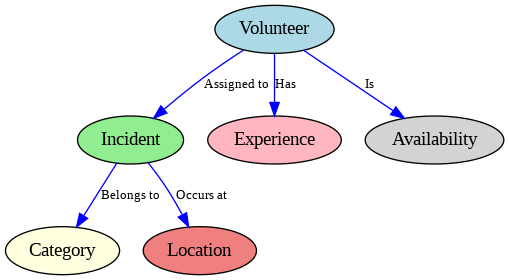

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydotplus
from IPython.display import Image

# Create an ERD diagram for the proposed system
graph = pydotplus.Dot(graph_type='digraph')

# Adding entities as nodes
volunteer = pydotplus.Node("Volunteer", shape="ellipse", style="filled", fillcolor="lightblue")
incident = pydotplus.Node("Incident", shape="ellipse", style="filled", fillcolor="lightgreen")
category = pydotplus.Node("Category", shape="ellipse", style="filled", fillcolor="lightyellow")
location = pydotplus.Node("Location", shape="ellipse", style="filled", fillcolor="lightcoral")
experience = pydotplus.Node("Experience", shape="ellipse", style="filled", fillcolor="lightpink")
availability = pydotplus.Node("Availability", shape="ellipse", style="filled", fillcolor="lightgray")

# Adding the nodes to the graph
graph.add_node(volunteer)
graph.add_node(incident)
graph.add_node(category)
graph.add_node(location)
graph.add_node(experience)
graph.add_node(availability)

# Adding relationships as edges
graph.add_edge(pydotplus.Edge(volunteer, incident, label="Assigned to", fontsize="10", color="blue"))
graph.add_edge(pydotplus.Edge(incident, category, label="Belongs to", fontsize="10", color="blue"))
graph.add_edge(pydotplus.Edge(incident, location, label="Occurs at", fontsize="10", color="blue"))
graph.add_edge(pydotplus.Edge(volunteer, experience, label="Has", fontsize="10", color="blue"))
graph.add_edge(pydotplus.Edge(volunteer, availability, label="Is", fontsize="10", color="blue"))

# Generate and display the diagram
Image(graph.create_png())


In [93]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='ERD for Volunteer Management System')

# Adding entities
dot.node('A', 'Volunteers')
dot.node('B', 'Events')
dot.node('C', 'Categories')
dot.node('D', 'Requests')

# Adding relationships
dot.edge('A', 'D', label='Handles')
dot.edge('B', 'D', label='Is for')
dot.edge('C', 'B', label='Classifies')

# Output the graph to a file
dot.render('volunteer_management_erd', format='png', cleanup=True)

# Display the graph
dot.view()

'volunteer_management_erd.pdf'